# Differential Expression Analysis - RhithroLoxo

## Set-up

If you've already saved the workspace image from a previous session, jupyter should automatically reload it. You may need to reload the packages though. The .RData file is not on GitHub, so you will have to actually run it the first time through. 

First, make sure you're actually running this from a compute node, not the login. On Poseidon, logins are 'l1' and 'l2', whereas all other nodes start with 'pn'.

In [1]:
Sys.info()

sysname                               release 
                              "Linux"           "3.10.0-693.2.2.el7.x86_64" 
                              version                              nodename 
"#1 SMP Tue Sep 12 22:26:13 UTC 2017"                               "pn109" 
                              machine                                 login 
                             "x86_64"                             "unknown" 
                                 user                        effective_user 
                            "ztobias"                             "ztobias"

Now load in the packages.

In [2]:
require(DESeq2)
require(ggplot2)
require(apeglm)
require(ashr)
library("BiocParallel")
register(MulticoreParam(12))
require(VennDiagram)
require(RColorBrewer)
require(pheatmap)

Loading required package: DESeq2
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching p

## Data import

Now import the count data, rounding decimals to integers.

In [3]:
path_to_main <- "/vortexfs1/scratch/ztobias/RhithroLoxo_DE/" #change accordingly based on parent file structure
path_to_counts <- "outputs/quant/salmon.isoform.counts.matrix"
path <- paste(path_to_main,path_to_counts,sep="")
all_counts <- read.table(path,header=TRUE)
all_counts <- round(all_counts)

Take a look.

In [4]:
head(all_counts)
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_C_6,AP_P_1,AP_P_2,AP_P_3,AP_P_6,...,NJ_P_7,SC_C_12,SC_C_14,SC_C_2,SC_C_6,SC_C_7,SC_C_9,SC_P_1,SC_P_2,SC_P_3
TRINITY_DN38930_c0_g1_i1,71,201,88,108,84,156,46,69,43,68,...,80,51,80,84,55,56,63,66,69,39
TRINITY_DN61353_c1_g1_i1,0,5,0,1,1,0,0,2,0,2,...,0,0,1,0,0,2,1,5,2,0
TRINITY_DN130836_c0_g1_i1,2,7,0,14,6,0,1,9,5,7,...,18,7,10,2,2,3,7,10,7,6
TRINITY_DN135735_c0_g1_i1,1,3,1,4,3,0,0,1,0,2,...,2,1,2,0,0,0,2,3,1,2
TRINITY_DN142305_c0_g1_i1,0,0,2,0,2,3,0,1,1,0,...,3,3,0,1,1,0,3,0,4,0
TRINITY_DN107975_c0_g1_i1,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 149511     83

Read in the sample metadata and have a look.

In [5]:
path_to_meta <- paste(path_to_main,"metadata/DESeq2_coldata.txt",sep="")
coldata <- read.table(path_to_meta,header=FALSE,row.names=1)
colnames(coldata) <- c("site","condition","range","sex")
head(coldata)
dim(coldata)

,site,condition,range,sex
AP_C_1,AP,C,Native,F
AP_C_2,AP,C,Native,F
AP_C_3,AP,C,Native,M
AP_C_4,AP,C,Native,M
AP_C_5,AP,C,Native,M
AP_C_6,AP,C,Native,M


[1] 83  4

Make sure the two matrices contain all of the same samples and are in order.

In [6]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

## Filtering

Okay here I am just going to calculate the normalized counts so I can try to identify transcripts whose highest representation occurs in the Loxo libraries. This is because there appears to be some latent contamination, either from index hopping or basal levels infection in otherwise "uninfected" crabs. This shows up downstream in some crazily overexpressed transcripts in the parasitized individuals, which appear not to be an actual response, but rather just contamination with parasite mRNA. This might not help completely because of tissue specific expression in the parasite (libraries made from externae, while contamination from internal, root-system tissues), but worth a shot. At least to strengthen the case for removal by thresholding later. 

The infected crabs will be excluded from this comparison. Because of tissue specific expression in the parasite, the highest expression of some contaminant transcripts may be expected in the infected crab libraries rather than those of the parasite itself. Thus, we are just looking for transcripts that are more highly represented in the parasite libraries than the control crab libraries.

Create a DESeq dataset just for the purpose of calculating normalized counts

In [7]:
contam <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ condition )

converting counts to integer mode


Estimate size factors and save normalized counts to object 'norm_mat'

In [8]:
contam <- estimateSizeFactors(contam)
norm_mat <- counts(contam, normalized=TRUE)

First let's remove the parasitized crabs. This includes all samples with the naming pattern `*_P_*`. The function `grepl()` returns a boolean vector that can be used to index. I will also remove sample MD_C_12, as this was identified to have a latent infection (unidentified infection detected in previous runs of this analysis).

In [9]:
norm_mat_sub <- norm_mat[,!grepl("*_P_*", colnames(norm_mat))]
norm_mat_sub <- subset(norm_mat_sub, select=-c(MD_C_12))

In [10]:
colnames(norm_mat_sub)

[1] "AP_C_1"  "AP_C_2"  "AP_C_3"  "AP_C_4"  "AP_C_5"  "AP_C_6"  "FP_C_10"
 [8] "FP_C_11" "FP_C_12" "FP_C_13" "FP_C_5"  "FP_C_9"  "LA_C_1"  "LA_C_2" 
[15] "LA_C_3"  "LA_C_4"  "LA_C_6"  "LA_C_8"  "LA_F_1"  "MA_C_1"  "MA_C_2" 
[22] "MA_C_4"  "MD_C_10" "MD_C_11" "MD_C_1"  "MD_C_4"  "MD_C_7"  "MD_F_4" 
[29] "ML_C_10" "ML_C_2"  "ML_C_3"  "ML_C_5"  "ML_C_7"  "ML_C_9"  "NH_C_11"
[36] "NH_C_12" "NH_C_13" "NH_C_5"  "NH_C_8"  "NH_C_9"  "NJ_C_10" "NJ_C_11"
[43] "NJ_C_12" "NJ_C_13" "NJ_C_14" "NJ_C_6"  "SC_C_12" "SC_C_14" "SC_C_2" 
[50] "SC_C_6"  "SC_C_7"  "SC_C_9"

Column numbers of the parasite samples in norm_mat_sub are 19 and 28. Command below finds the index of the maximum column for each row, checks if it matches 19 or 28 (the parasite samples), returns boolean which is used to subset the dataframe.  Let's take a look at a slice of the output to verify it's behavior. Parasite samples follow the naming pattern `*_F_*`.

In [11]:
contam_subset <- norm_mat_sub[max.col(norm_mat_sub) %in% c(19,28),]
contam_subset[1:20,18:29]

,LA_C_8,LA_F_1,MA_C_1,MA_C_2,MA_C_4,MD_C_10,MD_C_11,MD_C_1,MD_C_4,MD_C_7,MD_F_4,ML_C_10
TRINITY_DN130836_c0_g1_i1,8.342821,4515.9519,5.394225,1.521581,5.038778,5.136595,4.485368,4.048551,5.319531,4.6419802,729.6896,2.551833
TRINITY_DN6090_c0_g1_i1,114.018547,0.0000,149.959461,164.330783,157.461801,181.493023,146.522028,222.670320,189.729921,180.6152294,364.8448,146.305106
TRINITY_DN27882_c0_g1_i1,9.733291,694.7618,15.103831,10.651069,5.038778,14.553686,7.475614,14.169929,11.525649,9.2839604,0.0000,10.207333
TRINITY_DN33032_c0_g1_i1,8.342821,694.7618,6.473070,9.129488,10.077555,9.417091,5.232930,6.072827,5.319531,5.9079748,729.6896,18.713444
TRINITY_DN815_c0_g2_i2,241.246561,0.0000,189.876728,313.445753,311.144519,116.429487,217.540358,204.451839,134.761439,316.9206478,364.8448,281.552268
TRINITY_DN12072_c0_g1_i2,261.408377,694.7618,126.224870,176.503434,238.082243,173.788131,299.024547,118.757504,238.492284,166.2672906,1094.5344,249.229046
TRINITY_DN131921_c0_g1_i1,56.314039,347.3809,53.942252,53.255346,23.934194,84.753817,79.989066,103.238057,57.628247,80.1796579,0.0000,83.359886
TRINITY_DN29174_c0_g1_i1,72.999680,347.3809,93.859519,80.643810,119.670969,63.351338,78.493944,95.140955,58.514836,142.2133932,0.0000,85.061108
TRINITY_DN39441_c0_g1_i1,25.723697,0.0000,43.153802,34.996371,22.674499,35.956165,38.873191,22.267032,32.803771,13.0819442,729.6896,143.753273
TRINITY_DN26877_c0_g1_i1,26.418932,694.7618,7.551915,4.564744,11.337250,24.826876,32.892700,18.218481,25.711064,16.4579298,0.0000,15.310999


Scrolling through, it's clear that these transcripts have the highest expression in at least one of the parasite samples. This is indicative of Loxo contamination in the Rhithro assembly. Interestingly, oftentimes even when the highest value is in a parasite column, the other parasite column has a value of zero. I am not quite sure what this could mean. Different expression patterns between the two parasite externae, with both ending up in the Rhithro assembly? 

Okay now I'm going to save the rownames for use later:

In [12]:
contam_IDs <- rownames(contam_subset)
length(contam_IDs)

[1] 5797

There are 5797 transcripts that have higher expression in a parasite sample than any of the "clean" samples. It's a large number, but relative to the ~150K transcripts, not really.

I am now going to remove the Loxo samples from the raw expression matrix and sample metadata, and make another DESeq dataset object. 

In [13]:
all_counts <- all_counts[,-c(29,41)]
coldata <- coldata[-c(29,41),]

Verify again that the counts and metadata match up:

In [14]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay let's get started. This part of the analysis is just going to do a base comparison between uninfected and parasitized.

In [15]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


In [16]:
dds <- DESeq(dds, parallel=TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 12 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 12 workers


Let's visualize the data using some PCAs. This will be helpful for identifying sample outliers.

First we'll apply a variance stabilizing transformation to our normalized counts. 

In [17]:
vsd <- vst(dds, blind=FALSE)

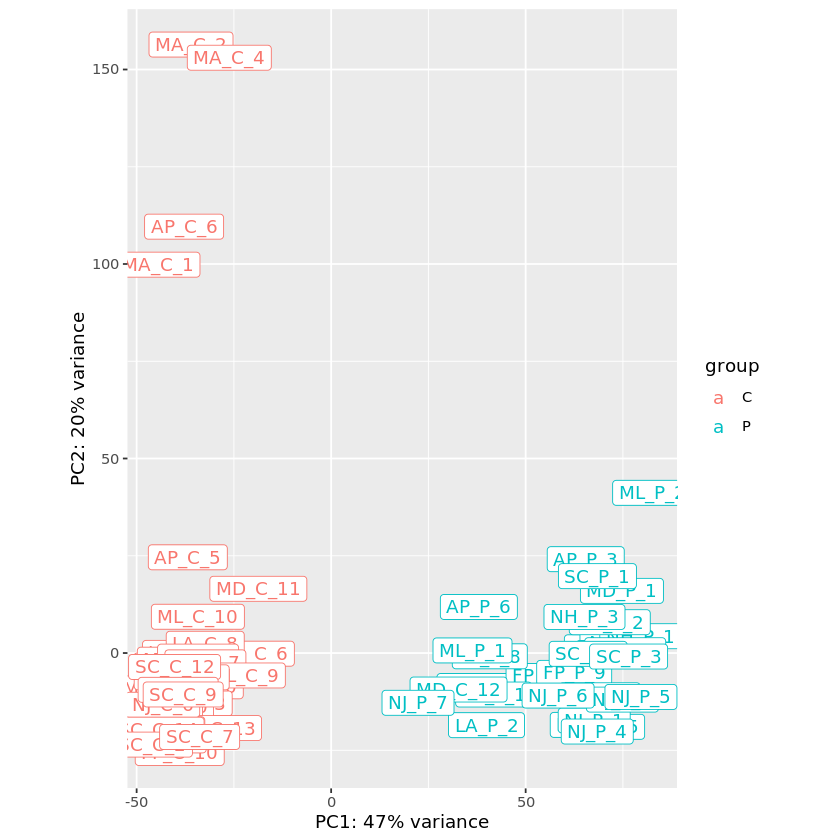

In [18]:
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see that PCA 1 clearly separates the sample according to infection status (whether this is due to a crab response or contamination from parasite remains to be seen...). Along the second PCA axis, you can see four extreme outlier at the upper left corner. Let's investigate this a little more closely by looking at the expression of particular high variance transcripts. 

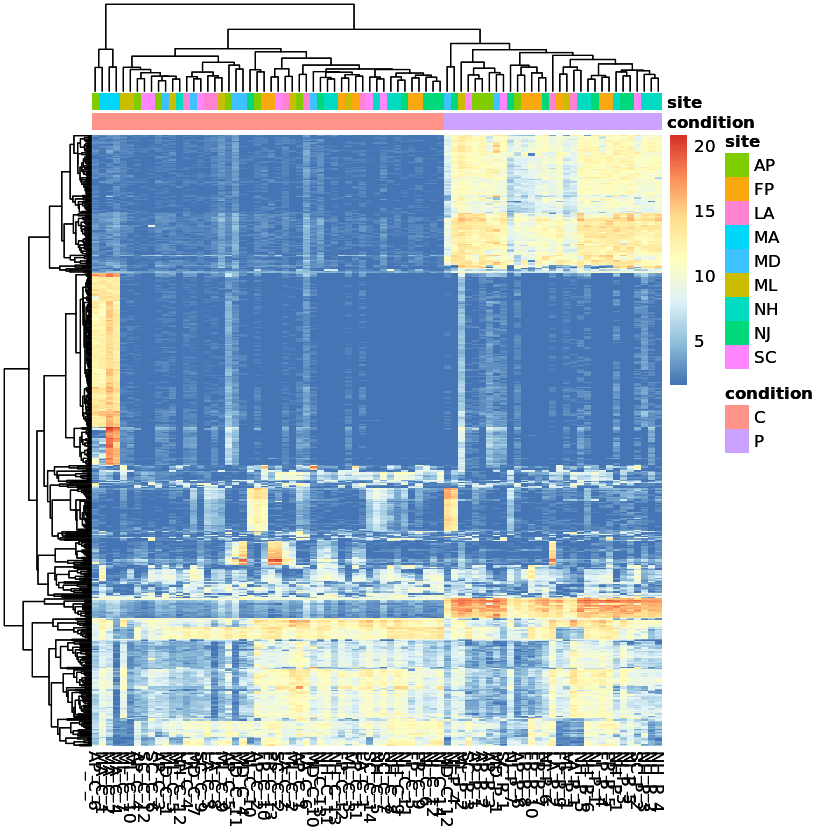

In [19]:
topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 500)
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd_df <- assay(vsd)
heatmap <- pheatmap(vsd_df[topVarGenes,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap

Looking at the top 500 highest variance transcripts, you can see that the transcript cluster second from the top separates samples in the same way as PCA axis 2 from above, with MA_C_1, MA_C_2, MA_C_4, and AP_C_6 having really high expression. Let's figure out what those are. 

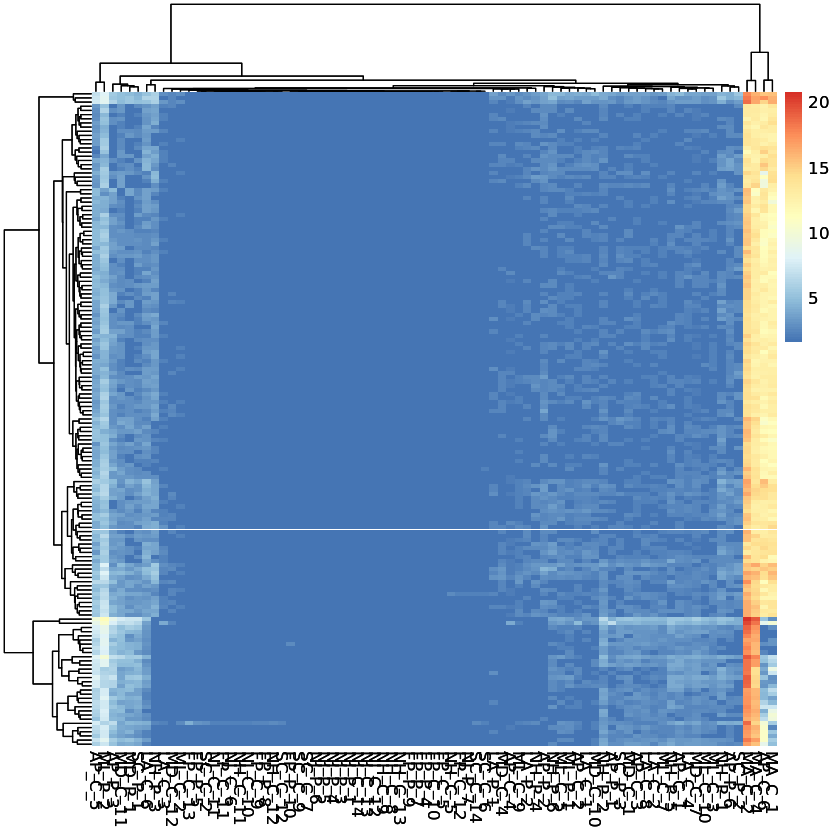

In [20]:
idx <- sort(cutree(heatmap$tree_row, k=10)) #separate transcripts by cluster assignment
idx <- names(which(idx==6)) #after searching, cluster 6 is the one with the transcripts we want
heatmap <- pheatmap(vsd_df[idx,], cluster_rows=TRUE, show_rownames=FALSE, cluster_cols=TRUE)
heatmap

Okay now we found the cluster that has all of these transcripts. Let's get the names and search annotations. Load in annotations.

In [21]:
annot <- read.table("../EnTAP/entap_outfiles/similarity_search/DIAMOND/overall_results/best_hits_lvl0.tsv", sep="\t", fill=TRUE, header=TRUE, quote="")

In [22]:
outlier_annot <- annot[annot[,1] %in% rownames(vsd[idx,]),] #get matching annotations
head(outlier_annot[order(outlier_annot[,11]),c(1,2,3,11,12,13,14)], 20) #show results

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
10388,TRINITY_DN93898_c0_g1_i1,CEO94640.1,68.4,3.7e-291,95.0,CEO94640.1 hypothetical protein PBRA_000425 [Plasmodiophora brassicae],plasmodiophora brassicae
15124,TRINITY_DN764_c0_g1_i1,sp|P49951|CLH1_BOVIN,32.7,5.5e-270,92.0,sp|P49951|CLH1_BOVIN Clathrin heavy chain 1 OS=Bos taurus OX=9913 GN=CLTC PE=1 SV=1,bos taurus
13216,TRINITY_DN3369_c0_g1_i1,tr|A0A2P2I4J8|A0A2P2I4J8_9CRUS,47.1,2.7e-228,93.9,tr|A0A2P2I4J8|A0A2P2I4J8_9CRUS Piwi-like protein 4 (Fragment) OS=Hirondellea gigas OX=1518452 PE=2 SV=1,hirondellea gigas
4980,TRINITY_DN11670_c0_g1_i10,XP_013782023.2,38.0,1.3e-216,78.8,XP_013782023.2 U5 small nuclear ribonucleoprotein 200 kDa helicase-like [Limulus polyphemus],limulus polyphemus
9088,TRINITY_DN4882_c0_g1_i1,sp|O02192|HSP83_DROAV,55.1,1.9e-192,94.9,sp|O02192|HSP83_DROAV Heat shock protein 83 OS=Drosophila auraria OX=47315 GN=Hsp83 PE=3 SV=1,drosophila auraria
3706,TRINITY_DN3073_c0_g1_i4,tr|A0A2U5IDQ7|A0A2U5IDQ7_MACRS,55.6,3.7e-180,87.1,tr|A0A2U5IDQ7|A0A2U5IDQ7_MACRS Glucose regulated protein 78 OS=Macrobrachium rosenbergii OX=79674 GN=GRP78 PE=2 SV=1,macrobrachium rosenbergii
12080,TRINITY_DN129176_c0_g1_i1,XP_018497583.1,36.6,5.6e-180,96.7,XP_018497583.1 probable phospholipid-transporting ATPase IIA [Galendromus occidentalis],galendromus occidentalis
16390,TRINITY_DN9317_c0_g1_i1,tr|A0A2P2I7L9|A0A2P2I7L9_9CRUS,57.6,9.5e-172,81.6,tr|A0A2P2I7L9|A0A2P2I7L9_9CRUS Lysine--tRNA ligase (Fragment) OS=Hirondellea gigas OX=1518452 PE=2 SV=1,hirondellea gigas
14890,TRINITY_DN9382_c0_g1_i1,Q42971.2,68.2,1.4e-170,93.8,Q42971.2 RecName: Full=Enolase; AltName: Full=2-phospho-D-glycerate hydro-lyase; AltName: Full=2-phosphoglycerate dehydratase; AltName: Full=OSE1,
10602,TRINITY_DN2622_c0_g1_i2,tr|L1J5W8|L1J5W8_GUITC,65.1,8.6e-158,78.6,tr|L1J5W8|L1J5W8_GUITC Adenosylhomocysteinase OS=Guillardia theta (strain CCMP2712) OX=905079 GN=GUITHDRAFT_110013 PE=3 SV=1,guillardia theta (strain ccmp2712)


There doesn't seem to be anything special about these transcripts, though it's hard to tell just from the reference IDs. I will dig into this a bit more later. It is likely they reflect some other process in the crab, such as molting, both Carolyn and I previously observed in earlier rounds of this analysis...

Either way, I am going to remove these outlier samples. They are contributing too much variation and will present issues when trying to fit the DESeq2 models and cause issues with count normalization. 

In [23]:
all_counts <- all_counts[,!(colnames(all_counts) %in% c("MA_C_1","MA_C_2","MA_C_4","AP_C_6"))]
all_counts[1:6,1:6]
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_P_1
TRINITY_DN38930_c0_g1_i1,71,201,88,108,84,46
TRINITY_DN61353_c1_g1_i1,0,5,0,1,1,0
TRINITY_DN130836_c0_g1_i1,2,7,0,14,6,1
TRINITY_DN135735_c0_g1_i1,1,3,1,4,3,0
TRINITY_DN142305_c0_g1_i1,0,0,2,0,2,0
TRINITY_DN107975_c0_g1_i1,0,0,0,0,0,0


[1] 149511     77

Okay now you can see the four of them were removed. Now make sure the coldata matches.

In [24]:
coldata <- coldata[colnames(all_counts),]
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay good let's make another dds object.

In [25]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


In [26]:
dds <- DESeq(dds, parallel=TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 12 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 12 workers


In [27]:
res <- results(dds, alpha=0.05)
summary(res)


out of 146756 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1587, 1.1%
LFC < 0 (down)     : 1655, 1.1%
outliers [1]       : 2527, 1.7%
low counts [2]     : 38896, 27%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Here we see that there are 1587 transcripts deemed significantly upregulated in parasitized crabs, and 1655 significantly downregulated, according the the Wald test.

As mentioned earlier, it is my suspicion that some of these upregulated transcripts are contamination from Loxo. Let's have a look.

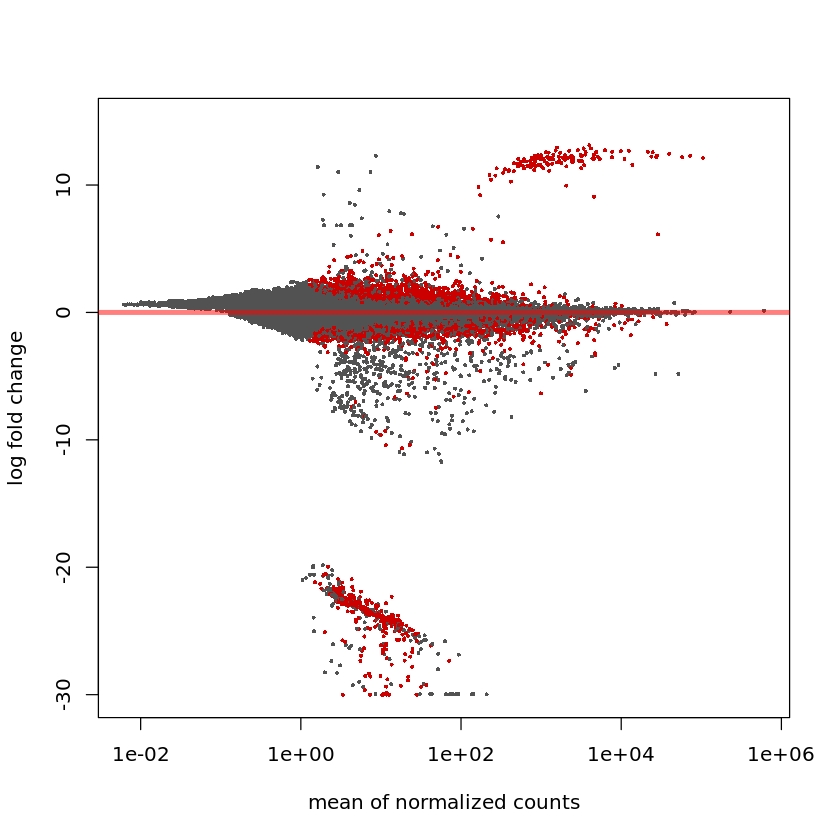

In [31]:
plotMA(res, ylim=c(-30,15))

Here we see the pattern I have alluded to, where there is a cloud of extremely overexpressed (>10 LFC) in the infected relative to the control. It is my suspicion that these represent contamination from Loxo rather than an actually response by the crabs. 

We also see a cloud of extremely underexpressed transcripts (<-20 LFC). I will deal with these after the Loxo contamination (but I can tell you now that these are contamination from trematodes and perhaps other parasites in three NH control crabs \[hence the lower count means\]).

Let's see if the OVERexpressed ones match the transcript IDs we pulled out earlier as possible Loxo contaminant transcripts. 

First let's make an ordered data.frame of the significant transcripts.

In [32]:
res_sig <- data.frame(subset(res, padj < 0.05))
res_sig <- res_sig[order(-res_sig$log2FoldChange),]
head(res_sig)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN54766_c0_g2_i1,4011.288,13.12440,0.7753760,16.92650,2.869305e-64,2.361192e-61
TRINITY_DN57720_c0_g1_i1,1575.042,12.94254,0.4599292,28.14029,3.150942e-174,8.734162e-171
TRINITY_DN106284_c0_g1_i1,3395.123,12.86814,0.4786270,26.88552,3.243707e-159,5.256452e-156
TRINITY_DN81798_c0_g1_i1,4201.369,12.86527,0.5721788,22.48470,5.860082e-112,5.321207e-109
TRINITY_DN120239_c0_g1_i1,2870.503,12.72487,0.4728986,26.90824,1.759063e-159,2.895115e-156
TRINITY_DN114680_c0_g1_i1,6259.348,12.72382,0.4614713,27.57229,2.391955e-167,5.360677e-164


You can see that there are some extremely significant, extremely overexpressed transcripts at the top, many of which have high rates of expression overall. These are likely contamination from Loxo. I am not sure how they made it into the transcriptome. It's hard to think of a biological reason. I am thinking this is due to index hopping during sequencing. If there were parasitizied and unparasitized crabs on the same lane (there were), then even a small amount of index hopping could have led to parasite reads being built into the txm, either as chimeras with crab sequences or alone. 

I am going to compare the list of transcripts I made earlier to these to see how much of an overlap there is. 

There are 3242 significant transcripts, 1587 up and 1655 down. There were 5797 transcripts that had higher expression in one of the two parasite samples than any of the clean samples. Let's look at the intersect. 

In [33]:
contam_intersect <- intersect(contam_IDs, rownames(res_sig))
length(contam_intersect)

[1] 484

Okay so there are 484 transcripts that came up as significant that were also identified as potential contamination. Let's see what the distribution of LFCs look like for these transcripts.

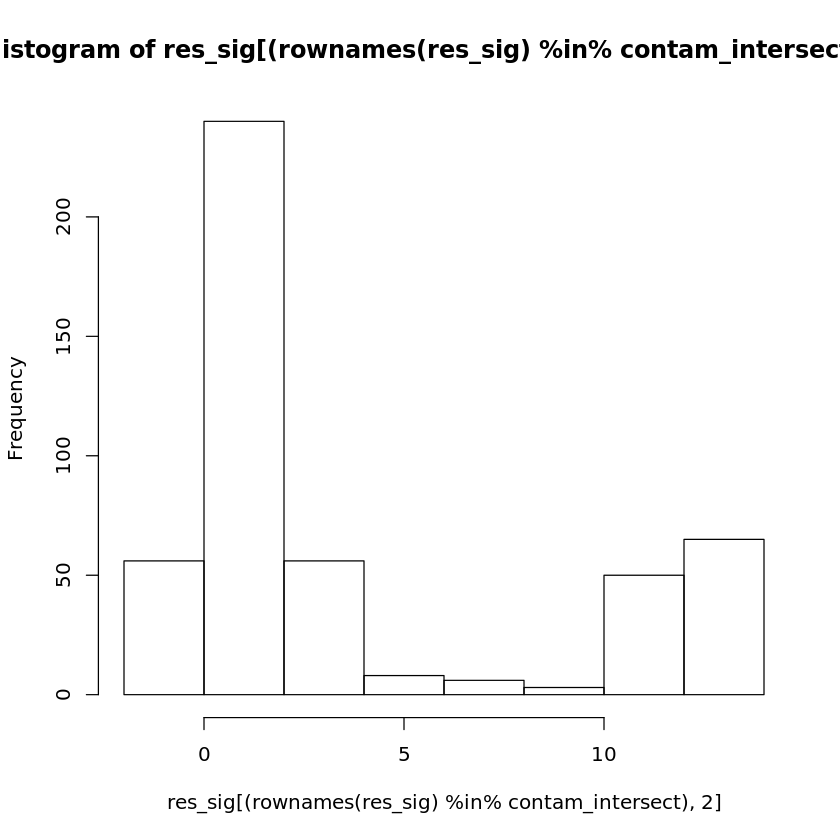

In [34]:
hist(res_sig[(rownames(res_sig) %in% contam_intersect),2])

It shows a bimodal pattern. Most of these transcripts are overexpressed, but a subset (~100) are extremely enriched. It is these that are most likely to be contamination. We will still consider all of these putative contamination and slate them for removal, as I believe it is more prudent to be liberal with what we discard.

*BUT HERE IS WHERE THE SEX-SPECIFIC EXPRESSION ISSUE COMES IN. LOXO EXTERNAE ARE FEMALE. IF PARASITIZED MALE CRABS ARE BEING FEMINIZED, THEY MAY EXPRESS FEMALE-BIASED TRANSCRIPTS THAT MAP TO FEMALE-SPECIFIC ORTHOLOGS FROM THE PARASITE (SINCE THEY ARE BOTH CRUSTACEANS, THERE MAY BE ENOUGH SEQUENCE HOMOLOGY FOR A MATCH). REMOVING ALL OF THEM HERE, INSTEAD OF JUST SIMPLE THRESHOLDING, MIGHT OBSCURE SIGNALS OF FEMINIZATION IN THE TRANSCRIPTOME. LEAVE AS IS FOR NOW, EXPLORE LATER.*

 Let's take a look at the significant results table with the putative Loxo contaminants removed.

In [35]:
head(res_sig[!(rownames(res_sig) %in% contam_intersect),],n=10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN94855_c0_g1_i1,818.242824,12.194390,0.4466536,27.301670,4.052334e-164,7.760809e-161
TRINITY_DN103226_c0_g1_i1,765.597664,12.155805,0.4838668,25.122213,2.844574e-139,3.366601e-136
TRINITY_DN121942_c0_g1_i1,730.919219,11.877771,0.4706129,25.238944,1.497841e-140,1.813473e-137
TRINITY_DN128205_c0_g1_i1,3066.964042,11.869844,0.4601489,25.795657,9.920000e-147,1.339620e-143
TRINITY_DN115787_c0_g1_i1,737.611108,11.578184,0.4608741,25.122227,2.843591e-139,3.366601e-136
TRINITY_DN122219_c0_g1_i1,615.855132,11.296783,0.4532567,24.923587,4.130268e-137,4.780808e-134
TRINITY_DN128046_c0_g1_i1,165.485629,9.851227,0.4250518,23.176530,7.854333e-119,7.257197e-116
TRINITY_DN146992_c0_g1_i1,5.882913,4.837203,0.8458548,5.718716,1.073323e-08,1.378735e-06
TRINITY_DN22600_c0_g1_i1,73.964123,4.524579,1.0450137,4.329684,1.493235e-05,1.093030e-03
TRINITY_DN51295_c0_g1_i1,18.506585,4.416180,0.6151665,7.178837,7.030708e-13,1.184905e-10


A lot of those transcripts are now removed. There are just around 7 of them left, depending on where you draw the line.

I am going to repeat visualization with all of putative Loxo contaminant transcripts removed. 

In [36]:
res2 <- results(subset(dds, !rownames(dds) %in% contam_IDs), alpha=0.05)

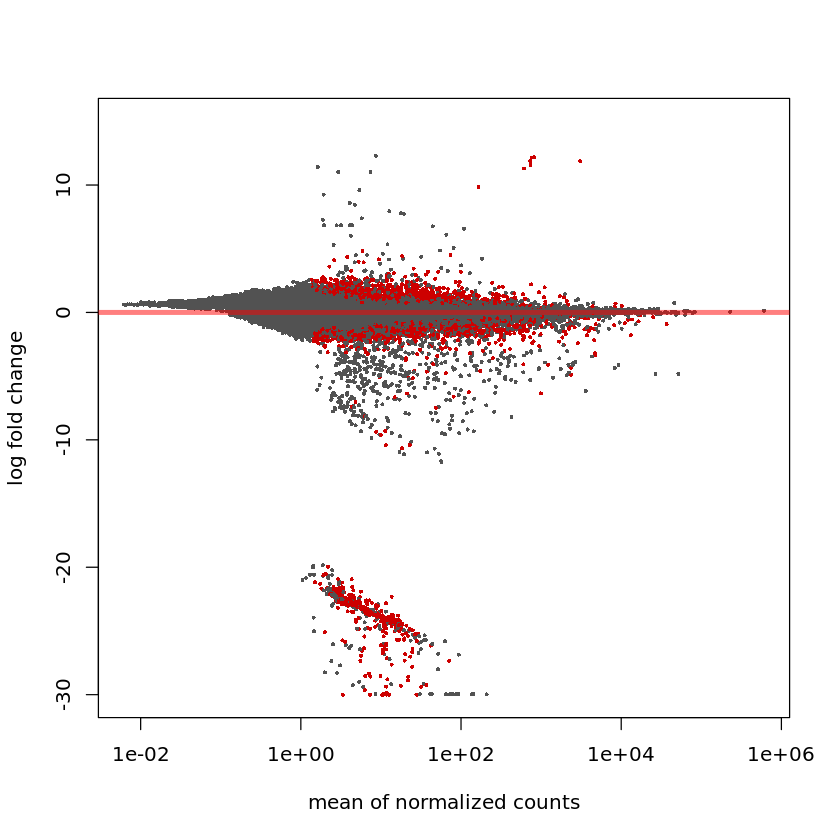

In [37]:
plotMA(res2, ylim=c(-30,15))

You can see now that the big cloud of points at the top right has mostly disappeared. A few points remain. I am still going to consider these as contamination and remove them by thresholding.

But first, let's look at the identity of the UNDERexpressed transcripts. Let's make a subset of the results without these transcripts, and then get the names of those transcripts. 

In [38]:
extra_under <- subset(res2, log2FoldChange < -15)
extra_under <- rownames(extra_under)
length(extra_under)

[1] 642

Now we'll make another vsd object and use the list of transcripts to plot just those that had extremely low LFCs.

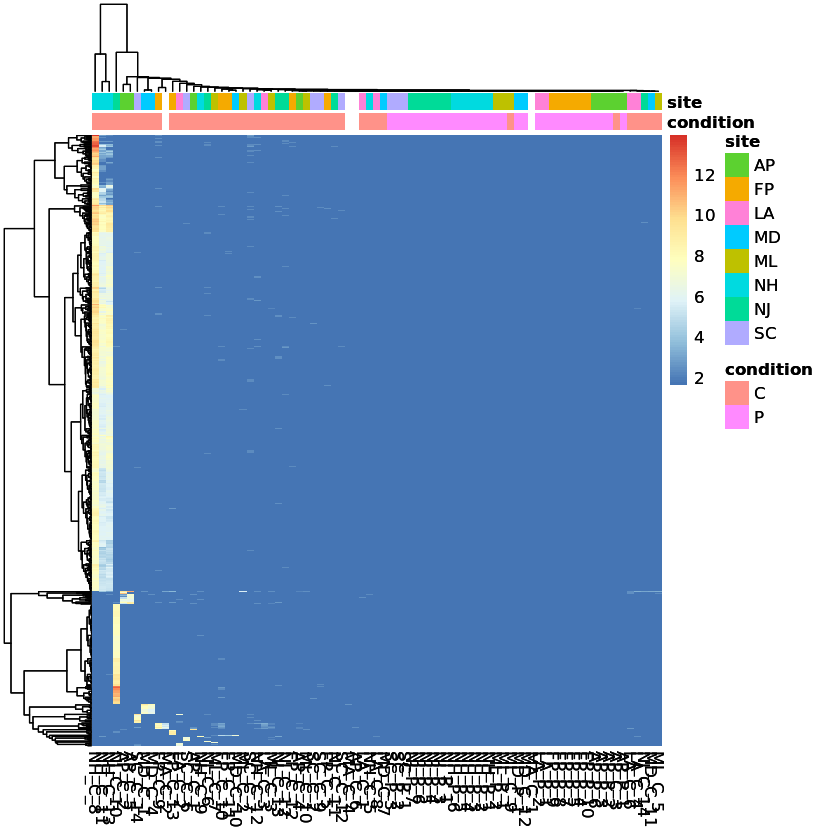

In [39]:
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd2 <- vst(dds, blind=TRUE)
vsd_df <- assay(vsd)
heatmap3 <- pheatmap(vsd_df[extra_under,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap3

It's clear that expression of these transcripts occurs in just a few crabs. It's difficult to see the sample names, but it is mostly in three control samples from NH (NH_C_8, NH_C_11, NH_C_13) and one from NJ (NJ_C_10). So these transcripts are only represented in a few samples. 

Let's use the annotations to figure out the identity of these transcripts.

In [40]:
low_annot <- annot[annot$Query.Sequence %in% extra_under,c(1,2,3,11,13,14)]
low_annot <- low_annot[order(low_annot$E.Value),]
low_annot

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Description,Species
7701,TRINITY_DN18400_c0_g1_i1,ORD95904.1,98.4,0.0e+00,ORD95904.1 hypothetical protein HERIO_2110 [Hepatospora eriocheir],hepatospora eriocheir
13067,TRINITY_DN145784_c0_g1_i1,THD18379.1,88.4,3.2e-220,THD18379.1 UDP-N-acetylglucosamine--peptide N-acetylglucosaminyltransferase 110 kDa subunit [Fasciola hepatica],fasciola hepatica
18633,TRINITY_DN110752_c0_g1_i1,sp|P79384|PCCB_PIG,75.5,1.6e-211,"sp|P79384|PCCB_PIG Propionyl-CoA carboxylase beta chain, mitochondrial OS=Sus scrofa OX=9823 GN=PCCB PE=1 SV=1",sus scrofa
17127,TRINITY_DN117850_c0_g1_i1,TNN17417.1,72.2,6.7e-201,TNN17417.1 Ubiquitin-like modifier-activating enzyme 1 isoform 2 [Schistosoma japonicum],schistosoma japonicum
8818,TRINITY_DN14648_c0_g1_i1,THD26774.1,77.3,8.3e-196,THD26774.1 Innexin [Fasciola hepatica],fasciola hepatica
6696,TRINITY_DN63237_c0_g1_i1,KAA3675984.1,87.1,1.3e-180,KAA3675984.1 phosphoglycerate kinase [Paragonimus westermani],paragonimus westermani
2582,TRINITY_DN145327_c0_g1_i1,KAA3680893.1,82.5,2.7e-180,KAA3680893.1 creatine kinase [Paragonimus westermani],paragonimus westermani
7687,TRINITY_DN28558_c0_g1_i2,tr|A0A075AIH6|A0A075AIH6_9TREM,85.5,3.3e-177,tr|A0A075AIH6|A0A075AIH6_9TREM Fructose-bisphosphate aldolase (Fragment) OS=Opisthorchis viverrini OX=6198 GN=T265_12938 PE=3 SV=1,opisthorchis viverrini
16713,TRINITY_DN28635_c0_g1_i1,GAA28380.1,83.5,3.0e-163,GAA28380.1 glyceraldehyde 3-phosphate dehydrogenase [Clonorchis sinensis],clonorchis sinensis
2249,TRINITY_DN63964_c0_g1_i1,sp|O18413|PRS8_DROME,91.6,1.4e-161,sp|O18413|PRS8_DROME 26S proteasome regulatory subunit 8 OS=Drosophila melanogaster OX=7227 GN=Rpt6 PE=1 SV=2,drosophila melanogaster


Looking through, it's clear that these represent contamination from a flatworm of some sort. Most if not all of the top matching hits are flatworms. There is also some Hepatospora, a fungal pathogen of crabs. 

Before we go on, I want to point out one transcript that shows an interesting pattern. Could be something to look more into after this first pass.

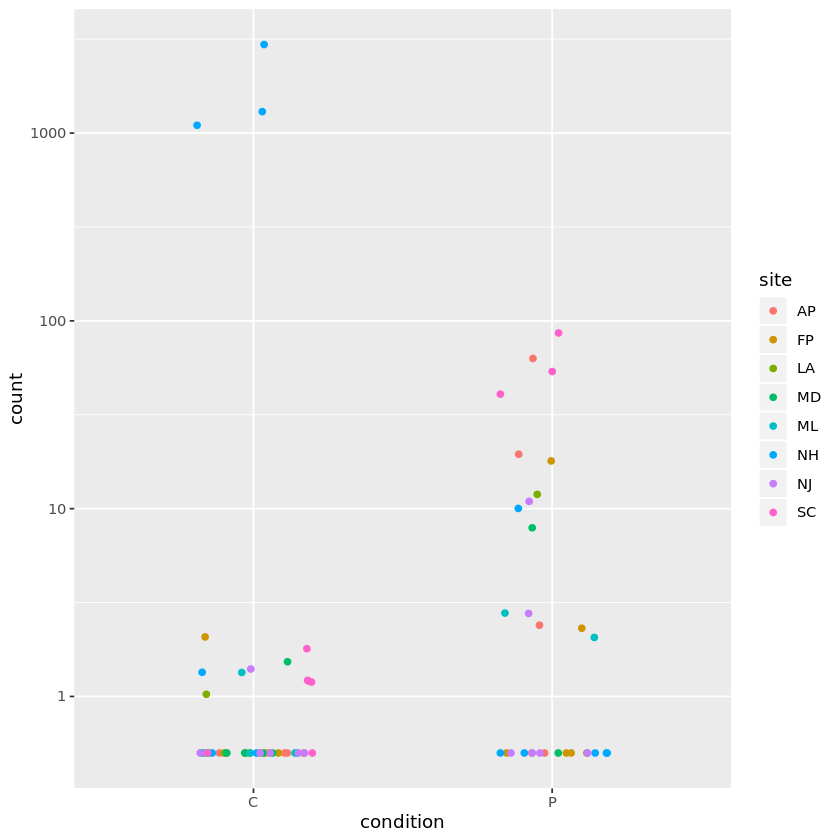

In [41]:
count_plot <- plotCounts(dds, gene="TRINITY_DN22600_c0_g1_i1", intgroup=c("condition","site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, color=site)) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    scale_y_log10()

Check out the annotation.

In [42]:
annot[annot[,1]=="TRINITY_DN22600_c0_g1_i1",c(1,2,3,4,5,11,12,13,14)]

,Query.Sequence,Subject.Sequence,Percent.Identical,Alignment.Length,Mismatches,E.Value,Coverage,Description,Species
12025,TRINITY_DN22600_c0_g1_i1,ADO32981.1,98.7,159,2,1.3e-78,99.6,ADO32981.1 polyubiquitin [Eriocheir sinensis],eriocheir sinensis


This transcript was found to be significantly upregulated in Loxo-infected crabs. However, you can see that it's also upregulated in the "control" crabs from New Hampshire that are likely infected with trematodes (see below for more evidence). The top hit for this transcript across five databases is a crab ubiquitin. This may represent a common response to trematode and Loxo infection, or cross mapping between trematode and crab ubiquitins.

This could be sometime to dig into more later. 

Okay, now I am going to remove all of these transcripts, not just those that map because many are lacking annotation. For removing both the putative Loxo and flatworm contaminants, I am going to set a threshold of an absolute value of 8. Let's look and see what that would remove, after already having flagged the putative Loxo for removal.

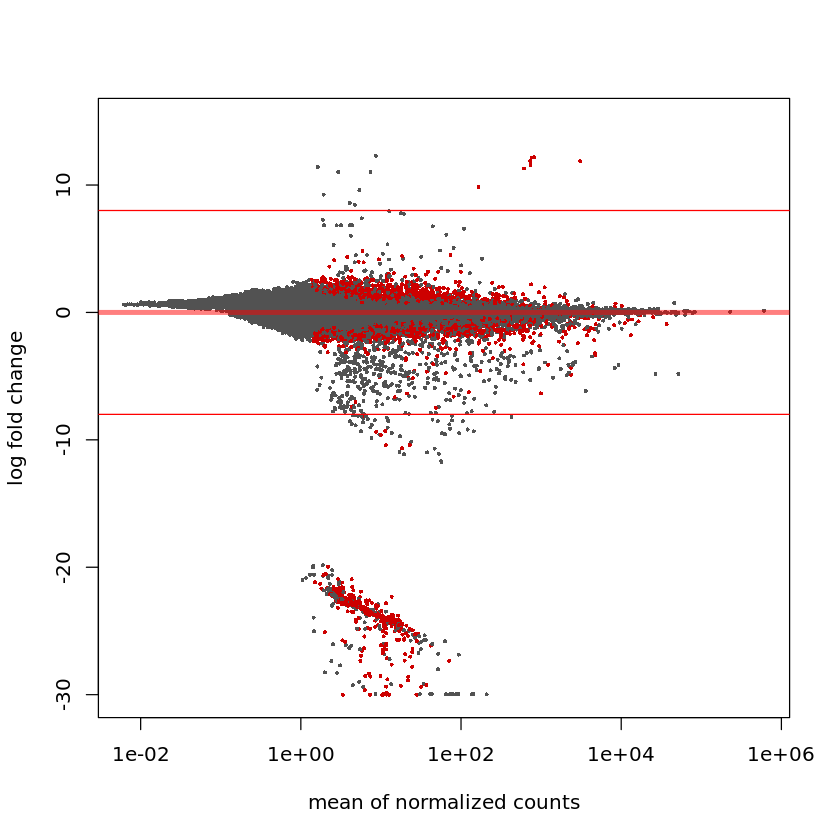

In [43]:
plotMA(res2, ylim=c(-30,15))
abline(h=8,col="red")
abline(h=-8,col="red")

Using 8 as a threshold would remove what I suspect to be lingering Loxo contamination at the top, and all of the putative flatworm contamination at the bottom. It will also remove a couple dozen transcripts closer towards the center. I think it is worth being liberal with what we throw out to ensure that the patterns we see in the data are reflective of crabs' responses to experimental Loxo infection instead of contamination from Loxo itself or other parasites. 

In [44]:
contam_add <- rownames(subset(res2, abs(log2FoldChange) > 8))
length(contam_add)

[1] 708

Okay here are the 708 remaining transcripts we deem to be contamination. I am going to add them to the list of contam_IDs, which will be used for removal from the intial counts object. Then the analysis will be re-run.

This is all to account for renormalization after removal, since many of these contigs had high mean expression across samples, especially the Loxo contaminants. I also want to have all of the putative contaminant transcripts removed before I do the WGCNA analysis. Because it looks for co-expression patterns among transcripts, if I leave in transcripts that are actually just contaminants, it will likely assign transcripts to modules not based on any functional relevance to particular pathways, but rather just to infection status. 

In [45]:
contam_IDs <- c(contam_IDs, contam_add)
length(contam_IDs)

[1] 6505

Okay successfully added. Now to reperform the anaysis.

## Parasitized vs. control differential expression 

In [46]:
dim(all_counts)
counts_clean <- all_counts[!rownames(all_counts) %in% contam_IDs,]
dim(counts_clean)

[1] 149511     77

[1] 143006     77

You can see that the 6505 putative contaminant transcripts have been removed.

Check that the sample names match between metadata and counts matrices.

In [47]:
all(rownames(coldata) == colnames(counts_clean))

[1] TRUE

Good. Create new dds object without the contaminant transcripts.

In [48]:
dds_clean <- DESeqDataSetFromMatrix(countData = counts_clean, colData = coldata, design = ~site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


Here we'll use a likelihood ratio test to control for site-specific effects. 

In [49]:
dds_clean <- DESeq(dds_clean, parallel=TRUE, test="LRT", reduced=~site)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 12 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 12 workers


In [50]:
resultsNames(dds_clean)

[1] "Intercept"        "site_FP_vs_AP"    "site_LA_vs_AP"    "site_MD_vs_AP"   
[5] "site_ML_vs_AP"    "site_NH_vs_AP"    "site_NJ_vs_AP"    "site_SC_vs_AP"   
[9] "condition_P_vs_C"

In [53]:
res_clean <- results(dds_clean, alpha=0.05, name="condition_P_vs_C")
summary(res_clean)


out of 140259 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 886, 0.63%
LFC < 0 (down)     : 758, 0.54%
outliers [1]       : 2281, 1.6%
low counts [2]     : 42494, 30%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Now you can see that we have 886 significantly upregulated transcripts and 758 significantly downregulated transcripts. There were a lot of transcripts that had too low of counts to be included (42494), though the creators of DESeq2 recommend not removing these before-hand because have all of the transcripts helps with the dispersion estimates. So, even though a lot got "thrown out", they are still helpful behind the scenes. This is almost certainly also an effect of having tossed out four outlier samples; all of the transcripts that were expressed almost exclusively in these individuals have low counts across the others.

Plot the unshrunk LFCs

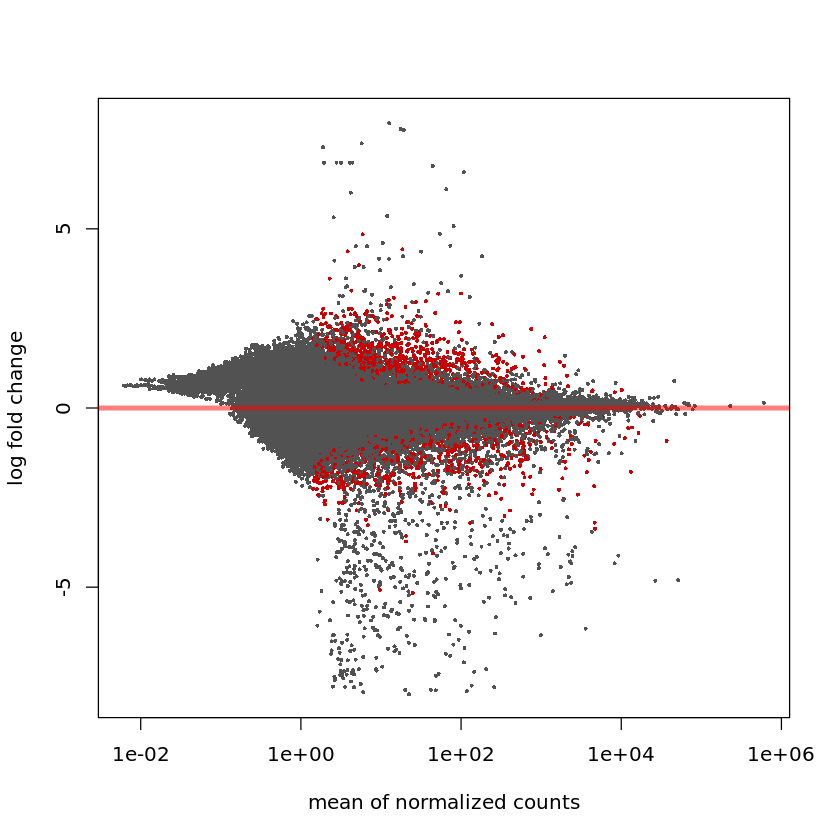

In [54]:
plotMA(res_clean, ylim=c(-8,8))

Now I'll shrink the LFCs for use later. 

In [55]:
res_clean_shrunk <- lfcShrink(dds_clean, coef="condition_P_vs_C", type="apeglm", parallel=TRUE)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


Plot the shrunk LFCs

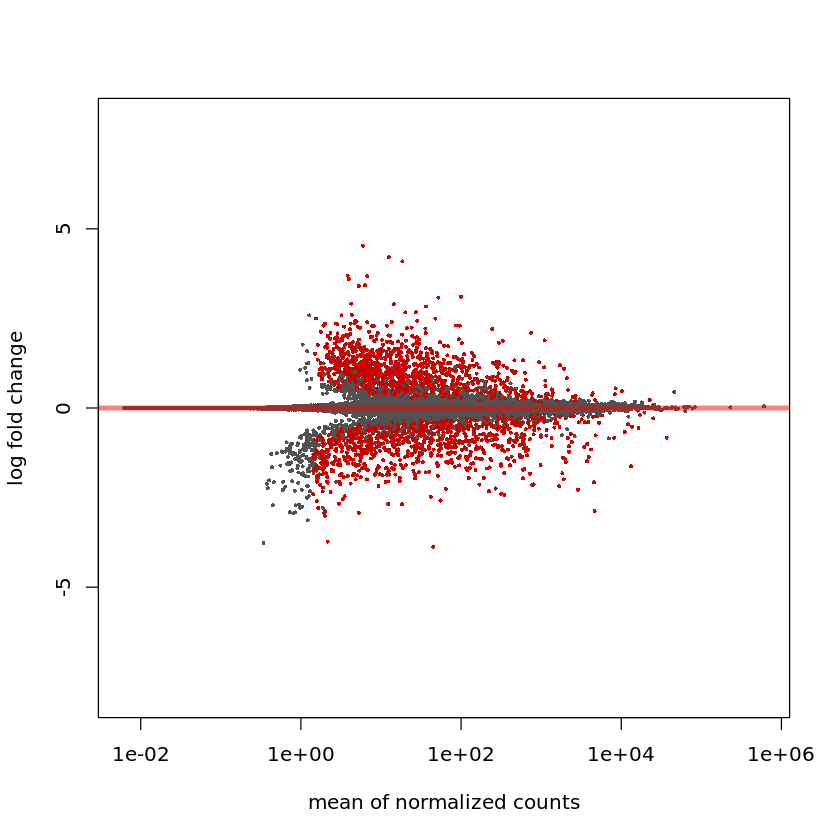

In [56]:
plotMA(res_clean_shrunk, ylim=c(-8,8))

Save the significant shrunk and unshrunk results:

In [57]:
res_clean_sig <- data.frame(subset(res_clean, padj < 0.05))
res_clean_shrunk_sig <- data.frame(subset(res_clean_shrunk, padj < 0.05))
res_clean_sig <- res_clean_sig[order(res_clean_sig$padj),]
res_clean_shrunk_sig <- res_clean_shrunk_sig[order(res_clean_shrunk_sig$padj),]
head(res_clean_sig,20)
#head(res_clean_sig[res_clean_sig$baseMean > 100,], 100) #subset the data in different to select IDs for countPlots

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN129162_c0_g1_i1,99.798713,3.1954791,0.35024093,73.97028,7.930190e-18,7.572062e-13
TRINITY_DN5780_c0_g1_i1,426.681391,-1.3999393,0.16890949,61.84021,3.724894e-15,1.185559e-10
TRINITY_DN153818_c0_g1_i1,52.041840,3.1921866,0.38068025,62.00753,3.421470e-15,1.185559e-10
TRINITY_DN10388_c0_g1_i1,40.116421,-1.8457000,0.23798447,53.79598,2.224269e-13,5.309552e-09
TRINITY_DN94593_c0_g1_i1,35.996665,-1.8666732,0.24126974,53.11433,3.146883e-13,6.009539e-09
TRINITY_DN26607_c0_g1_i1,96.198717,2.3929017,0.31435080,52.06601,5.366589e-13,8.540390e-09
TRINITY_DN78527_c0_g1_i1,86.125843,2.3960726,0.32207314,50.49517,1.194583e-12,1.425794e-08
TRINITY_DN112882_c0_g1_i1,13.399887,1.5517335,0.21289555,50.49915,1.192162e-12,1.425794e-08
TRINITY_DN59586_c1_g1_i1,35.914280,2.3153170,0.32446002,48.52447,3.261940e-12,3.460701e-08
TRINITY_DN11200_c0_g1_i2,192.171535,-2.0319096,0.26550695,47.87094,4.552193e-12,4.346616e-08


Now I'm going to make another PCA, now that the potential conaminants have been removed.

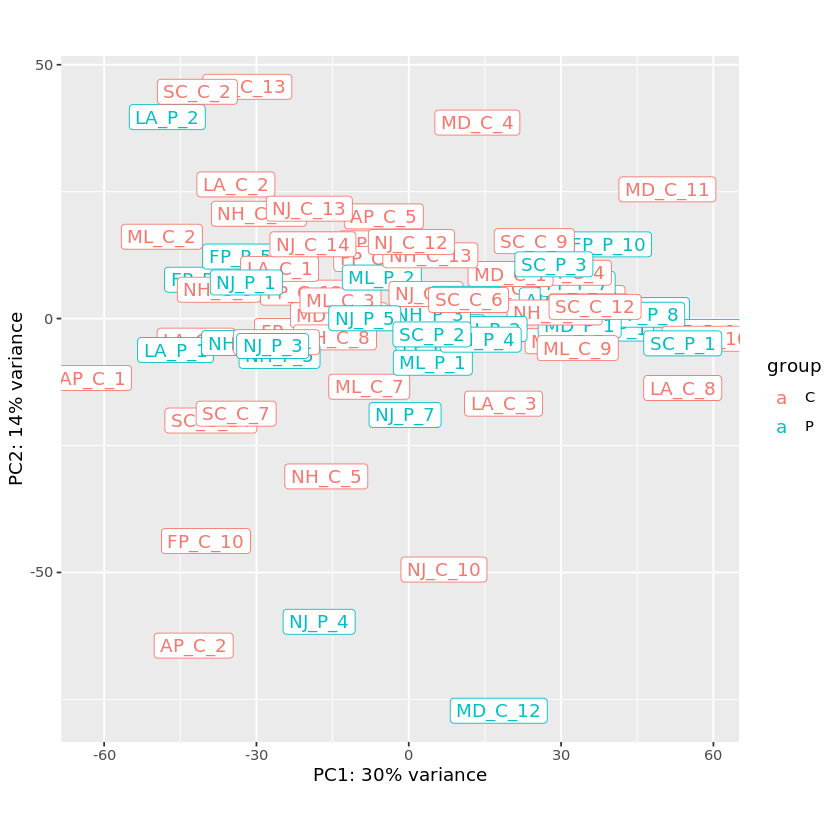

In [58]:
vsd <- vst(dds_clean, blind=FALSE)
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see now that they don't separate out. This is expected, as there is a lot of other variation present in the count data. This does not mean there aren't differences, however, as was shown above in the results summary. 

Just out of curiosity, let's plot one of the most significnatly differentially expressed transcripts and find it's annotation.

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
9311,TRINITY_DN4300_c0_g2_i2,ANN13869.1,67,0,63.4,ANN13869.1 glycogen debranching enzyme [Macrobrachium nipponense],macrobrachium nipponense


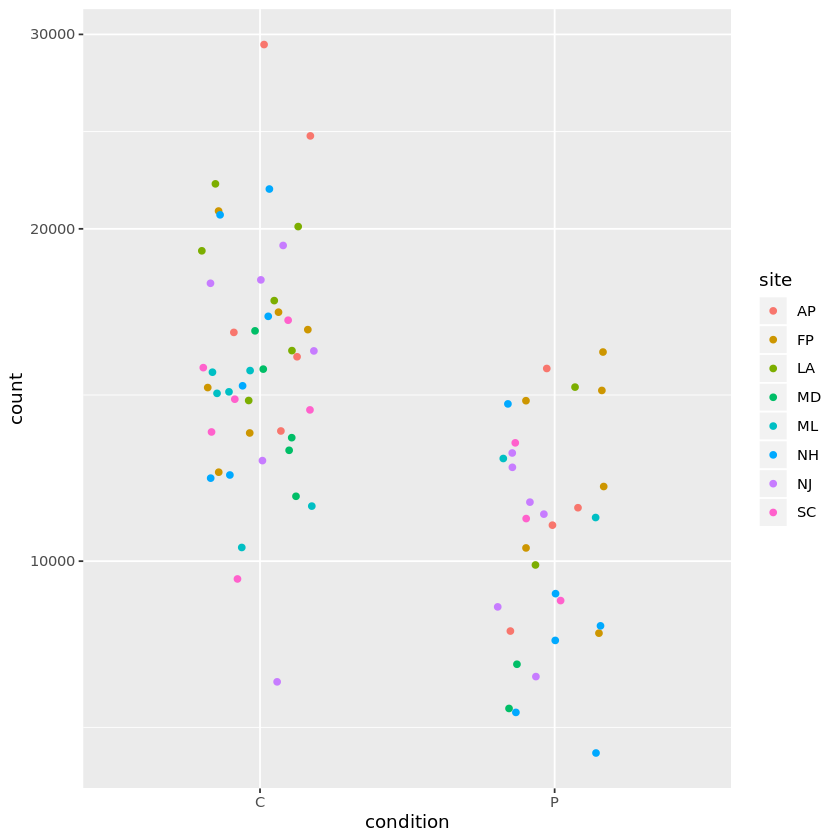

In [439]:
transcript <- "TRINITY_DN4300_c0_g2_i2"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_clean, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, color=site, group=range)) +
    #facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    scale_y_log10()

Laminin is involved in innate immunity in arthropods. Interesting to see that it is downregulated. Perhaps the parasite is suppressing the crabs response. 

## Range-specific effects

Now that we have looked for bulk differences as a result of infection status, we can move on to look at differences among populations with different levels of historical exposure to the parasite. We included the FP samples in our first comparison because it was agnostic to range. However, because it is unresolved whether Loxo is native, invasive, or absent from FP, we are going to remove it from subsequent analyses.

We have to make another dds object. I am going to make it from scratch by removing all FP samples from the coldata and counts_clean.

In [68]:
counts_clean_noFP <- counts_clean[,!grepl("FP_*_*",colnames(counts_clean))]
coldata_noFP <- coldata[colnames(counts_clean_noFP),]

Let's just check to make sure they were removed.

In [71]:
dim(counts_clean_noFP)

[1] 143006     65

Just a quick sanity check to make sure the samples are in the same order in the counts and metadata matrices.

In [246]:
all(rownames(coldata_noFP) == colnames(counts_clean_noFP))

[1] TRUE

Good. Now we can specify the model design and the reference levels. There is an added complication when correcting for individual effects that are nested within groups. I am implementing an approach outlined in the ["Group-specific condition effects, individuals nested within groups"](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#group-specific-condition-effects-individuals-nested-within-groups) section of the DESeq2 vignette.

In relation to the example in the vignette, for us 'site' is analogous to 'ind', 'condition' is to 'cnd', and 'range' is to 'grp'. We want to ensure that observed differences in response to infection among ranges is due to differences in coevolutionary history, not a result of the idiosyncracies of each population. 

We have to manually generate the model matrix in such a way that allows us to incorporate coefficients into the model that can correct for population effects. We'll edit the `coldata_noFP`. Let's have a look for a baseline:


*I ACTUALLY DON'T THINK YOU CAN CONTROL FOR SITE-SPECIFIC EFFECTS WHEN LOOKING AT THE INTERACTOIN BETWEEN RANGE AND CONDITION. EACH SITE CAN ONLY OCCUR IN ONE RANGE, SO YOU CAN'T CONTROL FOR IT. THIS STRATEGY IS USEFUL FOR MAKING COMPARISONS AMONG RANGES BROADLY, BUT CANNOT EXPLICITLY CORRECT FOR SITE-SPECIFIC EFFECTS...*

In [247]:
print(coldata_noFP)

        site condition    range sex site.n
AP_C_1    AP         C   Native   F      1
AP_C_2    AP         C   Native   F      1
AP_C_3    AP         C   Native   M      1
AP_C_4    AP         C   Native   M      1
AP_C_5    AP         C   Native   M      1
AP_P_1    AP         P   Native   F      1
AP_P_2    AP         P   Native   F      1
AP_P_3    AP         P   Native   F      1
AP_P_6    AP         P   Native   M      1
LA_C_1    LA         C   Native   M      2
LA_C_2    LA         C   Native   M      2
LA_C_3    LA         C   Native   F      2
LA_C_4    LA         C   Native   M      2
LA_C_6    LA         C   Native   F      2
LA_C_8    LA         C   Native   F      2
LA_P_1    LA         P   Native   M      2
LA_P_2    LA         P   Native   M      2
MD_C_10   MD         C Invasive   M      1
MD_C_11   MD         C Invasive   M      1
MD_C_12   MD         P Invasive   F      1
MD_C_1    MD         C Invasive   M      1
MD_C_4    MD         C Invasive   M      1
MD_C_7    M

We have to add a column assigning unique factors to each population *within* each range. We are going to add a column with the following values:

In [248]:
coldata_noFP$site.n <- factor(c(1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3))
print(coldata_noFP)

        site condition    range sex site.n
AP_C_1    AP         C   Native   F      1
AP_C_2    AP         C   Native   F      1
AP_C_3    AP         C   Native   M      1
AP_C_4    AP         C   Native   M      1
AP_C_5    AP         C   Native   M      1
AP_P_1    AP         P   Native   F      1
AP_P_2    AP         P   Native   F      1
AP_P_3    AP         P   Native   F      1
AP_P_6    AP         P   Native   M      1
LA_C_1    LA         C   Native   M      2
LA_C_2    LA         C   Native   M      2
LA_C_3    LA         C   Native   F      2
LA_C_4    LA         C   Native   M      2
LA_C_6    LA         C   Native   F      2
LA_C_8    LA         C   Native   F      2
LA_P_1    LA         P   Native   M      2
LA_P_2    LA         P   Native   M      2
MD_C_10   MD         C Invasive   M      1
MD_C_11   MD         C Invasive   M      1
MD_C_12   MD         P Invasive   F      1
MD_C_1    MD         C Invasive   M      1
MD_C_4    MD         C Invasive   M      1
MD_C_7    M

Now we can make a model matrix that includes the terms we want to use in our forumlae.

In [249]:
mm <- model.matrix(~ range + condition + range:site.n + range:condition, coldata_noFP)
head(mm)

,(Intercept),rangeInvasive,rangeAbsent,conditionP,rangeNative:site.n2,rangeInvasive:site.n2,rangeAbsent:site.n2,rangeNative:site.n3,rangeInvasive:site.n3,rangeAbsent:site.n3,rangeInvasive:conditionP,rangeAbsent:conditionP
AP_C_1,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_2,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_3,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_4,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_5,1,0,0,0,0,0,0,0,0,0,0,0
AP_P_1,1,0,0,1,0,0,0,0,0,0,0,0


It looks like our `coldata_FP` object still retained the `para` factor levels from we first read in the data to look for Loxo contamination. Let's get rid of those using `drop.levels()` from the `gdata` package. Then we'll make the model matrix again.

In [250]:
library(gdata)
coldata_noFP <- drop.levels(coldata_noFP)
mm <- model.matrix(~ range + condition + range:site.n + range:condition, coldata_noFP)
head(mm)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:SummarizedExperiment’:

    trim

The following object is masked from ‘package:Biobase’:

    combine

The following object is masked from ‘package:GenomicRanges’:

    trim

The following object is masked from ‘package:IRanges’:

    trim

The following objects are masked from ‘package:S4Vectors’:

    first, first<-

The following object is masked from ‘package:BiocGenerics’:

    combine

The following object is masked from ‘package:stats4’:

    nobs

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith



,(Intercept),rangeInvasive,rangeNative,conditionP,rangeAbsent:site.n2,rangeInvasive:site.n2,rangeNative:site.n2,rangeAbsent:site.n3,rangeInvasive:site.n3,rangeNative:site.n3,rangeInvasive:conditionP,rangeNative:conditionP
AP_C_1,1,0,1,0,0,0,0,0,0,0,0,0
AP_C_2,1,0,1,0,0,0,0,0,0,0,0,0
AP_C_3,1,0,1,0,0,0,0,0,0,0,0,0
AP_C_4,1,0,1,0,0,0,0,0,0,0,0,0
AP_C_5,1,0,1,0,0,0,0,0,0,0,0,0
AP_P_1,1,0,1,1,0,0,0,0,0,0,0,1


Okay now there is another issue. You can see from `mm` that the reference level has been set to `Absent`. We want it to be `Native`. Let's just relevel `coldata_noFP` and do it again. We'll also make sure the reference condition level is set to `C`, although it seems it already is.

In [251]:
coldata_noFP$range <- factor(coldata_noFP$range, levels = c("Native","Invasive","Absent"))
coldata_noFP$condition <- relevel(coldata_noFP$condition, ref = "C")

And make `mm` for the last time.

In [252]:
mm <- model.matrix(~ range + condition + range:site.n + range:condition, coldata_noFP)
head(mm)

,(Intercept),rangeInvasive,rangeAbsent,conditionP,rangeNative:site.n2,rangeInvasive:site.n2,rangeAbsent:site.n2,rangeNative:site.n3,rangeInvasive:site.n3,rangeAbsent:site.n3,rangeInvasive:conditionP,rangeAbsent:conditionP
AP_C_1,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_2,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_3,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_4,1,0,0,0,0,0,0,0,0,0,0,0
AP_C_5,1,0,0,0,0,0,0,0,0,0,0,0
AP_P_1,1,0,0,1,0,0,0,0,0,0,0,0


Okay this all looks good now. I am going to detach `gdata` just in case it causes any conflicts.

In [253]:
detach("package:gdata", unload=TRUE)

In [254]:
print(unname(mm))

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12]
 [1,]    1    0    0    0    0    0    0    0    0     0     0     0
 [2,]    1    0    0    0    0    0    0    0    0     0     0     0
 [3,]    1    0    0    0    0    0    0    0    0     0     0     0
 [4,]    1    0    0    0    0    0    0    0    0     0     0     0
 [5,]    1    0    0    0    0    0    0    0    0     0     0     0
 [6,]    1    0    0    1    0    0    0    0    0     0     0     0
 [7,]    1    0    0    1    0    0    0    0    0     0     0     0
 [8,]    1    0    0    1    0    0    0    0    0     0     0     0
 [9,]    1    0    0    1    0    0    0    0    0     0     0     0
[10,]    1    0    0    0    1    0    0    0    0     0     0     0
[11,]    1    0    0    0    1    0    0    0    0     0     0     0
[12,]    1    0    0    0    1    0    0    0    0     0     0     0
[13,]    1    0    0    0    1    0    0    0    0     0     0     0
[14,]    1    0    0    0    1    

There are some columns that are all zero, because some comparisons are missing. We'll remove them as outlined in the vignette.

In [255]:
all.zero <- apply(mm, 2, function(x) all(x==0))
idx <- which(all.zero)
mm <- mm[,-idx]
print(unname(mm))

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]    1    0    0    0    0    0    0    0    0     0
 [2,]    1    0    0    0    0    0    0    0    0     0
 [3,]    1    0    0    0    0    0    0    0    0     0
 [4,]    1    0    0    0    0    0    0    0    0     0
 [5,]    1    0    0    0    0    0    0    0    0     0
 [6,]    1    0    0    1    0    0    0    0    0     0
 [7,]    1    0    0    1    0    0    0    0    0     0
 [8,]    1    0    0    1    0    0    0    0    0     0
 [9,]    1    0    0    1    0    0    0    0    0     0
[10,]    1    0    0    0    1    0    0    0    0     0
[11,]    1    0    0    0    1    0    0    0    0     0
[12,]    1    0    0    0    1    0    0    0    0     0
[13,]    1    0    0    0    1    0    0    0    0     0
[14,]    1    0    0    0    1    0    0    0    0     0
[15,]    1    0    0    0    1    0    0    0    0     0
[16,]    1    0    0    1    1    0    0    0    0     0
[17,]    1    0    0    1    1 

Okay now we are going to create another model matrix to represent our reduced model to which the full model will be compared against with a likelihood ratio test.

In [256]:
mm_reduced <- model.matrix(~ range + condition + range:site.n, coldata_noFP)
all.zero2 <- apply(mm_reduced, 2, function(x) all(x==0))
idx2 <- which(all.zero2)
mm_reduced <- mm_reduced[,-idx2]
print(unname(mm_reduced))

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
 [1,]    1    0    0    0    0    0    0    0
 [2,]    1    0    0    0    0    0    0    0
 [3,]    1    0    0    0    0    0    0    0
 [4,]    1    0    0    0    0    0    0    0
 [5,]    1    0    0    0    0    0    0    0
 [6,]    1    0    0    1    0    0    0    0
 [7,]    1    0    0    1    0    0    0    0
 [8,]    1    0    0    1    0    0    0    0
 [9,]    1    0    0    1    0    0    0    0
[10,]    1    0    0    0    1    0    0    0
[11,]    1    0    0    0    1    0    0    0
[12,]    1    0    0    0    1    0    0    0
[13,]    1    0    0    0    1    0    0    0
[14,]    1    0    0    0    1    0    0    0
[15,]    1    0    0    0    1    0    0    0
[16,]    1    0    0    1    1    0    0    0
[17,]    1    0    0    1    1    0    0    0
[18,]    1    1    0    0    0    0    0    0
[19,]    1    1    0    0    0    0    0    0
[20,]    1    1    0    1    0    0    0    0
[21,]    1    1    0    0    0    

In [257]:
colnames(mm)
colnames(mm_reduced)

[1] "(Intercept)"              "rangeInvasive"           
 [3] "rangeAbsent"              "conditionP"              
 [5] "rangeNative:site.n2"      "rangeInvasive:site.n2"   
 [7] "rangeAbsent:site.n2"      "rangeInvasive:site.n3"   
 [9] "rangeInvasive:conditionP" "rangeAbsent:conditionP"

[1] "(Intercept)"           "rangeInvasive"         "rangeAbsent"          
[4] "conditionP"            "rangeNative:site.n2"   "rangeInvasive:site.n2"
[7] "rangeAbsent:site.n2"   "rangeInvasive:site.n3"

Okay now we can create a dds object. Let's just specify any simple design and then when we go to run `DESeq()`, we'll substitute in the model matrices. 

In [258]:
dds_range <- DESeqDataSetFromMatrix(countData = counts_clean_noFP, colData = coldata_noFP, design = ~ condition)

converting counts to integer mode


In [259]:
dds_range <- DESeq(dds_range, test="LRT", full=mm, reduced=mm_reduced, parallel=TRUE)

using supplied model matrix
estimating size factors
estimating dispersions
gene-wise dispersion estimates: 12 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 12 workers


In [260]:
resultsNames(dds_range)

[1] "Intercept"                "rangeInvasive"           
 [3] "rangeAbsent"              "conditionP"              
 [5] "rangeNative.site.n2"      "rangeInvasive.site.n2"   
 [7] "rangeAbsent.site.n2"      "rangeInvasive.site.n3"   
 [9] "rangeInvasive.conditionP" "rangeAbsent.conditionP"

Here are all the coefficients we can choose from. Let's just run the overall results, looking for all transcripts that display some kind of interaction

In [516]:
res_range <- results(dds_range, alpha=0.05, parallel=TRUE, name="rangeInvasive.conditionP") #if contrast or name not 
#specified, automatically extracts last term. this will be the p-values of the LRT, so it doesn't matter

In [517]:
res_range

log2 fold change (MLE): rangeInvasive.conditionP 
LRT p-value: full vs reduced 
DataFrame with 143006 rows and 6 columns
                                   baseMean       log2FoldChange
                                  <numeric>            <numeric>
TRINITY_DN38930_c0_g1_i1    84.231382844656     0.99654042278446
TRINITY_DN61353_c1_g1_i1   2.75457691815488     2.59288672041718
TRINITY_DN135735_c0_g1_i1  0.86908840845943    0.634737766611894
TRINITY_DN142305_c0_g1_i1  1.31990250020339   -0.144180651790647
TRINITY_DN107975_c0_g1_i1                 0                   NA
...                                     ...                  ...
TRINITY_DN154789_c0_g1_i1 0.723055240585736    0.863921961234806
TRINITY_DN61633_c0_g1_i1   3.18046211759197     1.03142912454347
TRINITY_DN114627_c0_g1_i1 0.672778717754719   0.0844587818244093
TRINITY_DN45973_c0_g1_i1   81.6671880643778 -0.00766383241436402
TRINITY_DN16666_c0_g1_i1   67.9293781268745   -0.154742588617686
                                  

In [558]:
res_range_df <- na.omit(data.frame(res_range))
res_range_df <- res_range_df[res_range_df$padj<0.05,]
res_range_df <- res_range_df[order(res_range_df$padj),]
head(res_range_df)
dim(res_range_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN2762_c0_g1_i2,927.58552,0.7015479,0.1326951,64.15132,1.174137e-14,9.019249e-10
TRINITY_DN22480_c0_g1_i1,48.74319,-0.9856213,0.3516789,57.27071,3.662877e-13,1.406838e-08
TRINITY_DN6746_c0_g1_i1,216.99005,-1.7010096,0.3295796,51.45677,6.703552e-12,1.716467e-07
TRINITY_DN30970_c0_g1_i1,29.26479,-1.5228012,0.4121595,50.51995,1.070860e-11,2.056479e-07
TRINITY_DN123458_c0_g1_i1,67.62941,-2.1961213,0.4459459,43.67558,3.280710e-10,5.040220e-06
TRINITY_DN3709_c0_g1_i2,237.21051,-1.1417382,0.2472835,42.95516,4.703322e-10,6.021507e-06


[1] 4463    6

So there are 4463 transcripts that display some sort of interaction. 

Let's look at some. Let's first for those that have annotations, sorted by padj.

In [568]:
head((rownames(res_range_df[rownames(res_range_df) %in% annot[,1],])),50)

[1] "TRINITY_DN2762_c0_g1_i2"   "TRINITY_DN283_c0_g1_i2"   
 [3] "TRINITY_DN3688_c0_g1_i1"   "TRINITY_DN8188_c0_g1_i1"  
 [5] "TRINITY_DN26483_c0_g1_i1"  "TRINITY_DN12438_c0_g1_i1" 
 [7] "TRINITY_DN92779_c0_g1_i1"  "TRINITY_DN13097_c0_g1_i1" 
 [9] "TRINITY_DN99921_c0_g1_i1"  "TRINITY_DN27427_c0_g1_i1" 
[11] "TRINITY_DN987_c0_g1_i1"    "TRINITY_DN54635_c0_g1_i1" 
[13] "TRINITY_DN66859_c0_g1_i1"  "TRINITY_DN12541_c0_g1_i1" 
[15] "TRINITY_DN83447_c0_g1_i1"  "TRINITY_DN97440_c0_g1_i1" 
[17] "TRINITY_DN3774_c0_g1_i1"   "TRINITY_DN45336_c0_g1_i1" 
[19] "TRINITY_DN150399_c0_g1_i1" "TRINITY_DN127782_c0_g1_i1"
[21] "TRINITY_DN10728_c0_g1_i1"  "TRINITY_DN6459_c3_g1_i1"  
[23] "TRINITY_DN11790_c0_g1_i1"  "TRINITY_DN16443_c0_g1_i1" 
[25] "TRINITY_DN27431_c1_g1_i1"  "TRINITY_DN57289_c0_g1_i1" 
[27] "TRINITY_DN13382_c0_g1_i2"  "TRINITY_DN16610_c0_g1_i1" 
[29] "TRINITY_DN52268_c0_g1_i1"  "TRINITY_DN22956_c0_g1_i1" 
[31] "TRINITY_DN23244_c0_g1_i1"  "TRINITY_DN2524_c0_g1_i3"  
[33] "TRINITY_DN6854_c0_g1_i2"   "TRINITY_DN78758_c0_g1_i1" 
[35] "TRINITY_DN111167_c0_g1_i1" "TRINITY_DN62036_c0_g1_i2" 
[37] "TRINITY_DN8682_c0_g1_i1"   "TRINITY_DN96177_c0_g1_i1" 
[39] "TRINITY_DN1718_c1_g1_i2"   "TRINITY_DN16338_c0_g1_i1" 
[41] "TRINITY_DN21043_c0_g1_i1"  "TRINITY_DN79154_c0_g1_i1" 
[43] "TRINITY_DN100388_c0_g1_i1" "TRINITY_DN6132_c0_g1_i1"  
[45] "TRINITY_DN15802_c0_g1_i1"  "TRINITY_DN78615_c0_g1_i1" 
[47] "TRINITY_DN135697_c0_g1_i1" "TRINITY_DN2830_c0_g1_i2"  
[49] "TRINITY_DN37750_c0_g1_i1"  "TRINITY_DN32424_c0_g1_i1"

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
12877,TRINITY_DN987_c0_g1_i1,tr|A0A5B7F0J2|A0A5B7F0J2_PORTR,94.9,0,86,tr|A0A5B7F0J2|A0A5B7F0J2_PORTR Rho guanine nucleotide exchange factor 10 OS=Portunus trituberculatus OX=210409 GN=ARHGEF10 PE=4 SV=1,portunus trituberculatus


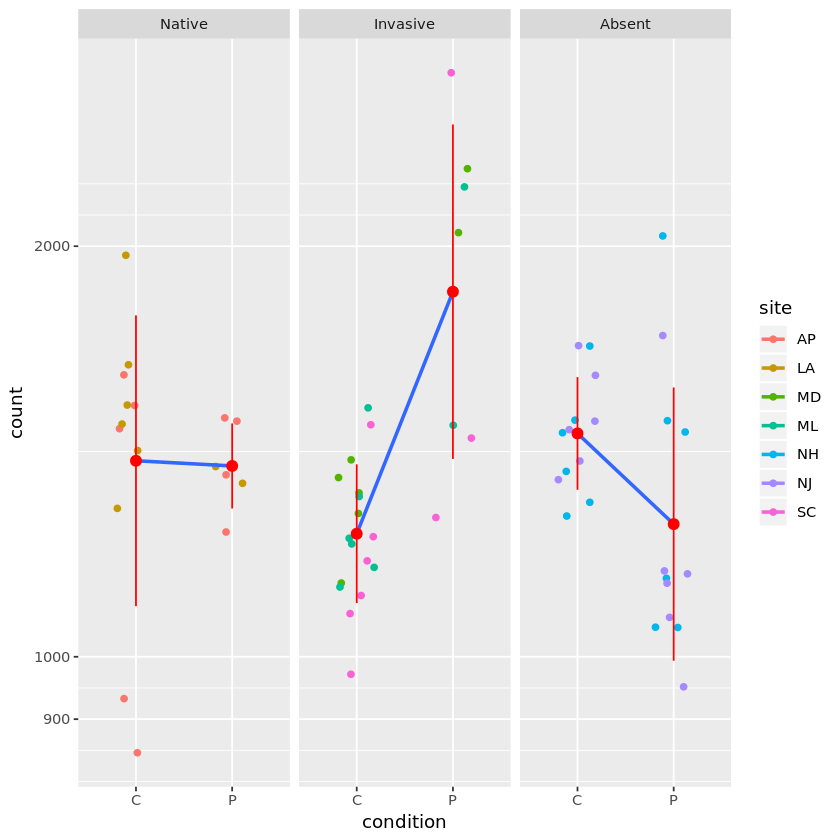

In [582]:
transcript <- "TRINITY_DN987_c0_g1_i1"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

*MORE STUFF HERE*

*THEN TRY TO MAKE CONTRASTS TO LOOK AT DIFFERENT DIRECTIONS OF THE INTERACTIONS BETWEEN RANGES*

In [466]:
res_range_IvA <- results(dds_range, alpha=0.05, test="Wald", parallel=TRUE, list( c('rangeInvasive.conditionP','rangeAbsent.conditionP')))


In [481]:
summary(res_range_IvA)


out of 140127 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 245, 0.17%
LFC < 0 (down)     : 215, 0.15%
outliers [1]       : 1882, 1.3%
low counts [2]     : 56093, 40%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [499]:
res_range_IvA_df <- na.omit(data.frame(res_range_IvA))
res_range_IvA_df <- res_range_IvA_df[res_range_IvA_df$padj<0.05,]
head(res_range_IvA_df[order(-res_range_IvA_df$baseMean),])
dim(res_range_IvA_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN28_c10_g1_i1,44024.6263,-17.791581,4.0371367,-4.406980,1.048218e-05,0.008047966
TRINITY_DN1728_c0_g1_i1,6577.9309,-2.514655,0.6915109,-3.636465,2.764049e-04,0.049999317
TRINITY_DN5469_c0_g1_i1,2228.2629,-4.303401,1.1637554,-3.697857,2.174274e-04,0.045800249
TRINITY_DN3581_c0_g1_i1,1752.4477,1.809261,0.4652619,3.888695,1.007847e-04,0.031390623
TRINITY_DN4125_c0_g1_i1,1013.8924,4.134157,1.1034264,3.746654,1.792091e-04,0.042033391
TRINITY_DN9438_c0_g1_i1,954.5109,-16.040944,4.3745968,-3.666839,2.455669e-04,0.047805243


[1] 460   6

*END CONTRASTS BETWEEN INTERACTIONS HERE*


I think we need to make contrasts. Then I can filter by names in the data.frames above and find out what percentage of significant transcripts are over/under in absent and invasive vs. native. <<<--- *STILL NEED TO DO THIS!*

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
10431,TRINITY_DN2762_c0_g1_i2,tr|A0A0P4VYU4|A0A0P4VYU4_9EUCA,89.8,0,58.3,tr|A0A0P4VYU4|A0A0P4VYU4_9EUCA TFCD_C domain-containing protein OS=Scylla olivacea OX=85551 PE=4 SV=1,scylla olivacea


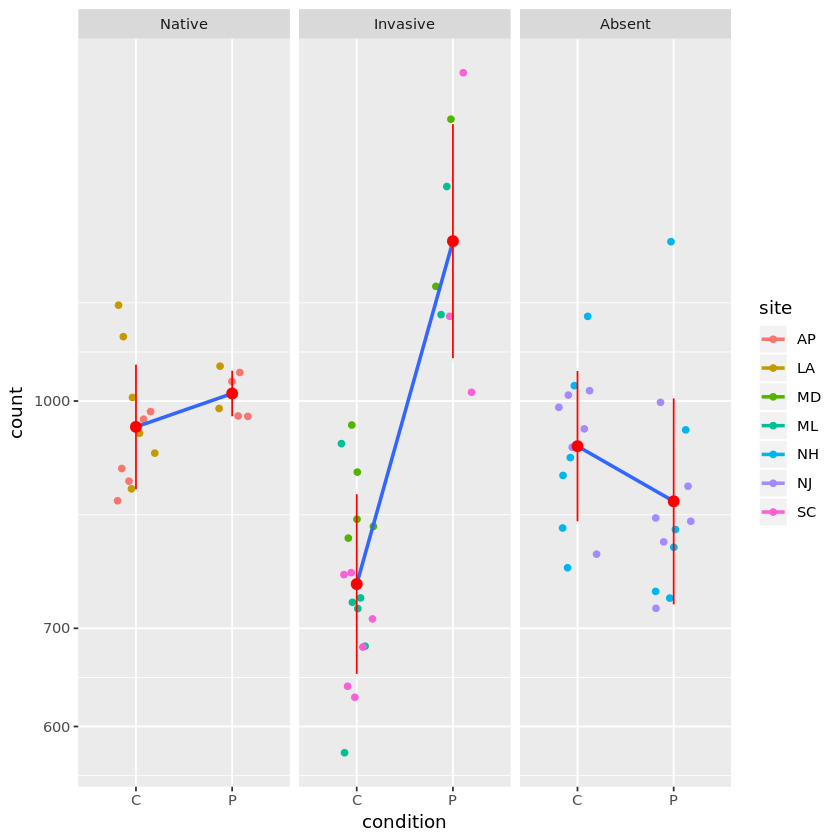

In [509]:
transcript <- "TRINITY_DN2762_c0_g1_i2"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

It's looking like for the most part when we see a significant interaction, the invasive populations have the opposite pattern of both the native AND the absent. What could this mean biologically? Naive hosts from the absent range display mostly similar responses to those from the native range. Is this evolutionarily meaningful? Hosts from the absent range haven't evolved to mount a defense in certain pathways, but neither do the native hosts, perhaps because they have a different resistance mechanism? Behavior? It might also be ecologically relevant in that the populations in the invasive range have really high parasite burdens, whereas in the native range it is really low, and none in the absent range (obviously). So it might just be that native hosts have means of avoiding parasitism that don't rely on mounting the sort of defense that those in the invasive range do. Should dig into this further.

Could be an effect of population size as well. Perhaps the gulf crab populations are just much bigger, so they have some demographic means of avoiding parasitism. The rate of parasitism is so low (chances of getting infected), that there isn't a incentive to evolve molecular defenses. Could be other ecological factors. Maybe there are predators of the parasite larvae in the native range that lessen load on the native hosts. Perhaps this predator is missing in the invasive range. I can't imagine there are many loxo-larvae-specialists, so I imagine rates of predation on them would be similar across environments... There are so many potential explanations. 

Maybe in the native range some transcripts that in the other ranges are upregulated during infection are just expressed at higher basal levels without infection, perhaps preemptively staving off the parasite. 

Let's make some contrasts. First let's remind ourselves of the coefficients.

In [352]:
resultsNames(dds_range)

[1] "Intercept"                "rangeInvasive"           
 [3] "rangeAbsent"              "conditionP"              
 [5] "rangeNative.site.n2"      "rangeInvasive.site.n2"   
 [7] "rangeAbsent.site.n2"      "rangeInvasive.site.n3"   
 [9] "rangeInvasive.conditionP" "rangeAbsent.conditionP"

To make contrasts among groups with this complex design, we should make use of numeric contrasts. Find a trick for doing this [here](http://seqanswers.com/forums/showthread.php?t=47766).

In [367]:
print(coldata_noFP)

        site condition    range sex site.n
AP_C_1    AP         C   Native   F      1
AP_C_2    AP         C   Native   F      1
AP_C_3    AP         C   Native   M      1
AP_C_4    AP         C   Native   M      1
AP_C_5    AP         C   Native   M      1
AP_P_1    AP         P   Native   F      1
AP_P_2    AP         P   Native   F      1
AP_P_3    AP         P   Native   F      1
AP_P_6    AP         P   Native   M      1
LA_C_1    LA         C   Native   M      2
LA_C_2    LA         C   Native   M      2
LA_C_3    LA         C   Native   F      2
LA_C_4    LA         C   Native   M      2
LA_C_6    LA         C   Native   F      2
LA_C_8    LA         C   Native   F      2
LA_P_1    LA         P   Native   M      2
LA_P_2    LA         P   Native   M      2
MD_C_10   MD         C Invasive   M      1
MD_C_11   MD         C Invasive   M      1
MD_C_12   MD         P Invasive   F      1
MD_C_1    MD         C Invasive   M      1
MD_C_4    MD         C Invasive   M      1
MD_C_7    M

In [387]:
#native contrasts is "Native + P" vs "Native + C"
native_contrasts <- colMeans(mm[coldata_noFP$range == "Native" & coldata_noFP$condition == "P",]) -
                    colMeans(mm[coldata_noFP$range == "Native" & coldata_noFP$condition == "C",])
#invasive contrasts is "Invasive + P" vs "Invasive + C"
invasive_contrasts <- colMeans(mm[coldata_noFP$range == "Invasive" & coldata_noFP$condition == "P",]) -
                    colMeans(mm[coldata_noFP$range == "Invasive" & coldata_noFP$condition == "C",])
#absent contrasts is "Absent + P" vs "Absent + C"
absent_contrasts <- colMeans(mm[coldata_noFP$range == "Absent" & coldata_noFP$condition == "P",]) -
                    colMeans(mm[coldata_noFP$range == "Absent" & coldata_noFP$condition == "C",])

Now that we have our numeric contrasts set up, we can go on do generating comparisons between our groups of interest. Instead of using the p-values from the likelihood ratio test performed in the `DESeq()` command, we specify a Wald test, which is more appopriate for contrasts. 

In [389]:
native.PvC <- results(dds_range, alpha=0.05, contrast=native_contrasts, test="Wald", parallel=TRUE)
invasive.PvC <- results(dds_range, alpha=0.05, contrast=invasive_contrasts, test="Wald", parallel=TRUE)
absent.PvC <- results(dds_range, alpha=0.05, contrast=absent_contrasts, test="Wald", parallel=TRUE)
summary(native.PvC)
summary(invasive.PvC)
summary(absent.PvC)


out of 140127 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 452, 0.32%
LFC < 0 (down)     : 373, 0.27%
outliers [1]       : 1882, 1.3%
low counts [2]     : 64110, 46%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 140127 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2013, 1.4%
LFC < 0 (down)     : 1195, 0.85%
outliers [1]       : 1882, 1.3%
low counts [2]     : 69477, 50%
(mean count < 4)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 140127 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 3963, 2.8%
LFC < 0 (down)     : 1190, 0.85%
outliers [1]       : 1882, 1.3%
low counts [2]     : 53430, 38%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Let's save the results to data.frames, both with the raw LFCs and shrunk using `ashr`, which is the preferred method when dealing with contrasts. 

*SHRINKING DOESN'T APPEAR TO BE COMPATIBLE WITH USER-DEFINED MATRICES AND NUMERIC CONTRASTS...*

In [435]:
native.PvC_df <- data.frame(subset(native.PvC, native.PvC$padj < 0.05))
native.PvC_df <- native.PvC_df[order(-native.PvC_df$baseMean),]
#native.PvC_shrunk <- lfcShrink(dds_range, contrast=native_contrasts, type="normal", parallel=TRUE)
#native.PvC_shrunk_df <- data.frame(subset(native.PvC_shrunk, native.PvC_shrunk$padj < 0.05))
#native.PvC_shrunk_df <- native.PvC_shrunk_df[order(native.PvC_shrunk_df$padj),]
invasive.PvC_df <- data.frame(subset(invasive.PvC, invasive.PvC$padj < 0.05))
invasive.PvC_df <- invasive.PvC_df[order(-invasive.PvC_df$baseMean),]
#invasive.PvC_shrunk <- lfcShrink(dds_range, contrast=invasive_contrasts, type="normal", parallel=TRUE)
#invasive.PvC_shrunk_df <- data.frame(subset(invasive.PvC_shrunk, invasive.PvC_shrunk$padj < 0.05))
#invasive.PvC_shrunk_df <- invasive.PvC_shrunk_df[order(invasive.PvC_shrunk_df$padj),]
absent.PvC_df <- data.frame(subset(absent.PvC, absent.PvC$padj < 0.05))
absent.PvC_df <- absent.PvC_df[order(-absent.PvC_df$baseMean),]
#absent.PvC_shrunk <- lfcShrink(dds_range, contrast=absent_contrasts, type="normal", parallel=TRUE)
#absent.PvC_shrunk_df <- data.frame(subset(absent.PvC_shrunk, absent.PvC_shrunk$padj < 0.05))
#absent.PvC_shrunk_df <- absent.PvC_shrunk_df[order(absent.PvC_shrunk_df$padj),]

Let's have a look at some of the top transcripts from each contrast sorted by `baseMean`, using the unshrunk LFCs (the shrinking didn't seem to work with the contrasts, all of the tables the same dimensions... I am not sure if `ashr` is compatible with numeric contrats in the `lfcShrink()` function. No shrinking done.)

In [437]:
head(native.PvC_df, 20)
head(invasive.PvC_df, 20)
head(absent.PvC_df, 20)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN4300_c0_g2_i2,13812.382,-0.6704670,0.1656242,-4.048123,5.163005e-05,0.013450628
TRINITY_DN867_c0_g1_i6,5880.819,-0.4697183,0.1341982,-3.500183,4.649386e-04,0.045707652
TRINITY_DN5500_c0_g1_i3,5364.843,-1.2227263,0.3184367,-3.839778,1.231454e-04,0.023229983
TRINITY_DN3964_c0_g1_i1,5246.282,-4.6754964,1.3356828,-3.500454,4.644659e-04,0.045707652
TRINITY_DN3964_c1_g1_i6,5147.095,-4.8009084,1.2943200,-3.709213,2.079046e-04,0.029986403
TRINITY_DN2676_c0_g1_i1,4497.497,-1.5089017,0.4100609,-3.679701,2.335071e-04,0.031821787
TRINITY_DN12148_c0_g1_i1,3991.012,-2.2160405,0.5061341,-4.378367,1.195721e-05,0.005195133
TRINITY_DN1562_c0_g1_i1,3878.280,-1.0302588,0.2888551,-3.566697,3.615089e-04,0.039899290
TRINITY_DN4419_c1_g1_i1,3584.400,-0.9301059,0.2326100,-3.998564,6.372804e-05,0.015490093
TRINITY_DN2760_c1_g1_i1,3246.467,-0.9241938,0.1925891,-4.798786,1.596300e-06,0.001376066


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN7050_c0_g1_i1,69551.17,0.4991366,0.14564295,3.427125,6.100090e-04,2.265682e-02
TRINITY_DN1885_c0_g1_i1,67559.66,0.9560851,0.28216259,3.388419,7.029679e-04,2.449367e-02
TRINITY_DN1912_c0_g1_i1,63172.64,-0.8871695,0.28837966,-3.076394,2.095206e-03,4.700590e-02
TRINITY_DN2815_c0_g1_i2,45022.56,1.6649249,0.50360493,3.306014,9.463336e-04,2.920892e-02
TRINITY_DN28_c10_g1_i1,44024.63,-7.2625688,1.50940504,-4.811544,1.497688e-06,5.144696e-04
TRINITY_DN4816_c0_g1_i1,42225.43,0.7416233,0.21319141,3.478673,5.039023e-04,2.027367e-02
TRINITY_DN4626_c1_g1_i1,25712.56,1.0307056,0.27473746,3.751602,1.757083e-04,1.082716e-02
TRINITY_DN1193_c0_g1_i4,25254.60,0.3767503,0.11345906,3.320584,8.982936e-04,2.845410e-02
TRINITY_DN2127_c0_g1_i2,23276.38,-1.0513912,0.30074325,-3.495976,4.723312e-04,1.955525e-02
TRINITY_DN454_c0_g1_i2,22714.25,0.7323237,0.16344269,4.480614,7.442851e-06,1.454062e-03


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN92626_c0_g1_i1,59799.569,-0.5781048,0.1794109,-3.222239,1.271931e-03,0.0302002391
TRINITY_DN922_c0_g2_i9,48403.465,-0.7896956,0.1941079,-4.068333,4.735064e-05,0.0046002800
TRINITY_DN178_c0_g1_i3,37469.489,-1.6608617,0.3279494,-5.064385,4.097219e-07,0.0002447223
TRINITY_DN1531_c0_g1_i1,27604.259,-0.6306277,0.1869582,-3.373095,7.432836e-04,0.0224587113
TRINITY_DN521_c0_g1_i2,23999.836,-0.5800602,0.1862033,-3.115198,1.838215e-03,0.0374239639
TRINITY_DN20480_c0_g1_i1,20115.283,-0.5059210,0.1319037,-3.835533,1.252922e-04,0.0081057651
TRINITY_DN1605_c0_g1_i4,17154.828,-0.4398096,0.1143781,-3.845226,1.204413e-04,0.0079249286
TRINITY_DN1002_c0_g1_i1,16550.821,-0.5642587,0.1630064,-3.461575,5.370247e-04,0.0188447470
TRINITY_DN1675_c0_g1_i4,15455.226,-1.1900783,0.3399282,-3.500969,4.635691e-04,0.0173212578
TRINITY_DN4300_c0_g2_i2,13812.382,-0.6818272,0.1332450,-5.117094,3.102792e-07,0.0002088598


,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
3504,TRINITY_DN513_c0_g1_i1,AID47198.1,100,4.9e-89,99.6,"AID47198.1 beta-actin, partial [Macrophthalmus japonicus]",macrophthalmus japonicus


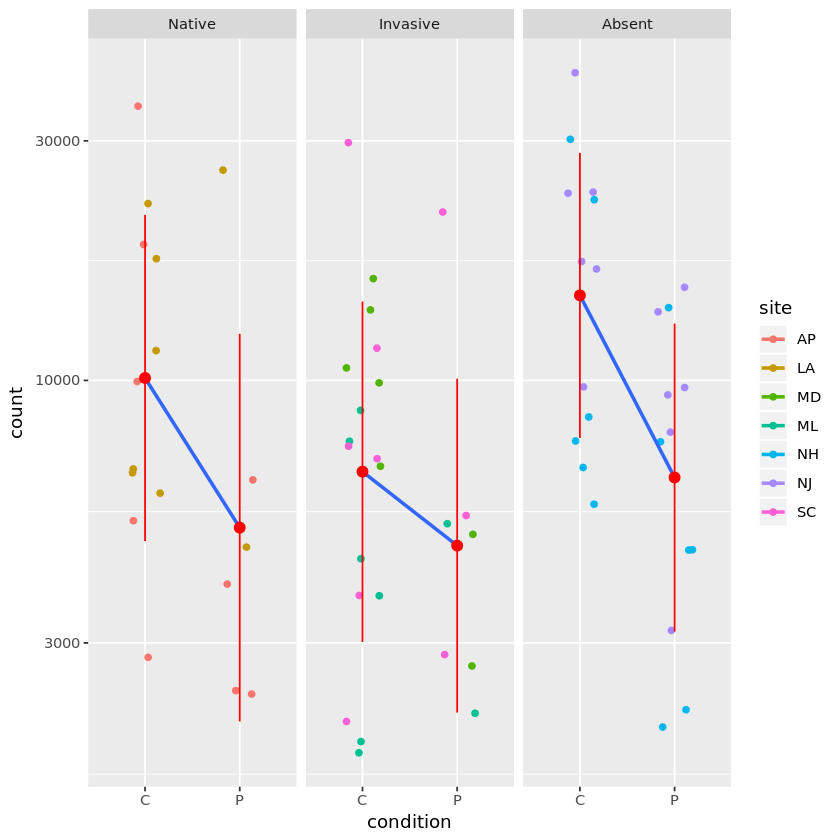

In [438]:
transcript <- "TRINITY_DN513_c0_g1_i1"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

Okay now I am going to make lists of names of up and downregulated transcripts for each range, so we can make Venn diagrams.

In [428]:
native_DE_up <- rownames(native.PvC_df[native.PvC_df$log2FoldChange>0,])
native_DE_down <- rownames(native.PvC_df[native.PvC_df$log2FoldChange<0,])
invasive_DE_up <- rownames(invasive.PvC_df[invasive.PvC_df$log2FoldChange>0,])
invasive_DE_down <- rownames(invasive.PvC_df[invasive.PvC_df$log2FoldChange<0,])
absent_DE_up <- rownames(absent.PvC_df[absent.PvC_df$log2FoldChange>0,])
absent_DE_down <- rownames(absent.PvC_df[absent.PvC_df$log2FoldChange<0,])
length(native_DE_up)
length(native_DE_down)
length(invasive_DE_up)
length(invasive_DE_down)
length(absent_DE_up)
length(absent_DE_down)

[1] 452

[1] 373

[1] 2013

[1] 1195

[1] 3963

[1] 1190

Good, these correspond to the numbers seen earlier in the summaries.

Now to make some Venn diagrams.

In [429]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
myCol <- brewer.pal(3, "Set1")
venn.diagram(
        x = list(native_DE_up, invasive_DE_up, absent_DE_up),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_up.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)
venn.diagram(
        x = list(native_DE_down, invasive_DE_down, absent_DE_down),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_down.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)
venn.diagram(
        x = list(c(native_DE_down,native_DE_up), c(invasive_DE_down,invasive_DE_up), c(absent_DE_down,absent_DE_up)),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_both.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)

NULL

[1] 1

[1] 1

[1] 1

*MORE HERE*

I'm going to check out some that are shared. 

In [456]:
intersect(intersect(native_DE_down, invasive_DE_down), absent_DE_down)

[1] "TRINITY_DN46_c0_g1_i3"    "TRINITY_DN5780_c0_g1_i1" 
 [3] "TRINITY_DN2460_c0_g1_i1"  "TRINITY_DN6206_c0_g1_i2" 
 [5] "TRINITY_DN6783_c0_g1_i1"  "TRINITY_DN6618_c0_g1_i1" 
 [7] "TRINITY_DN15994_c0_g1_i1" "TRINITY_DN11200_c0_g1_i2"
 [9] "TRINITY_DN3532_c0_g1_i1"  "TRINITY_DN4017_c2_g1_i1" 
[11] "TRINITY_DN19207_c0_g1_i1" "TRINITY_DN5143_c1_g1_i1" 
[13] "TRINITY_DN10388_c0_g1_i1" "TRINITY_DN94593_c0_g1_i1"
[15] "TRINITY_DN41255_c0_g1_i1" "TRINITY_DN18860_c0_g1_i1"
[17] "TRINITY_DN31494_c0_g1_i1"

Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species


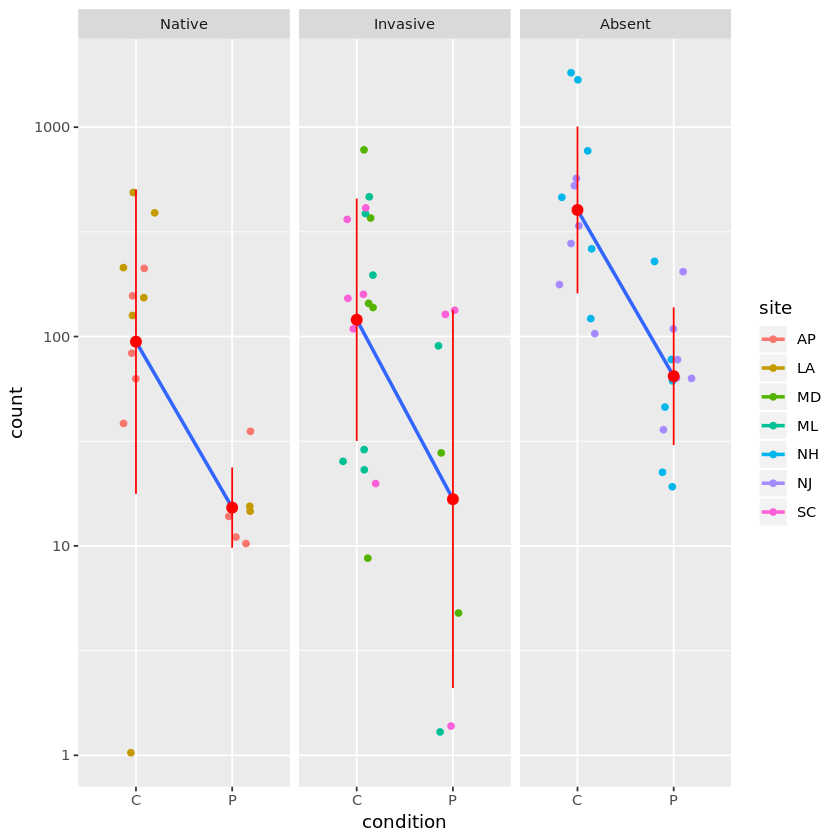

In [457]:
transcript <- "TRINITY_DN15994_c0_g1_i1"
annot[annot[,1]==transcript,c(1,2,3,11,12,13,14)]
count_plot <- plotCounts(dds_range, gene=transcript, intgroup=c("condition","range", "site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

Before we finish, I need to export a matrix of counts to use downstream in WGCNA. The creators [suggest](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html) removing transcripts with consistently low counts to avoid spurious correlations, and the also recommend performing a variance stabilizing transformation. I will do both below and then export as a tsv/

I am going to export both on containing FP individuals and one without. 

I am removing all transcripts that have normalized counts of less than 10 in over 90% of the samples (72/81 for clean, 62/69 for clean_noFP).

REDO this below!!q

In [ ]:
filterGenes <- rowSums(counts(dds_clean, normalized=TRUE) < 10 ) > 72
for_export <- dds_clean[!filterGenes,]
vsd <- vst(for_export, blind=TRUE)
write.table(assays(vsd)[[1]], file = "../outputs/WGCNA_FP_in.tsv", sep="\t")
filterGenes <- rowSums(counts(dds_range, normalized=TRUE) < 10 ) > 62
for_export <- dds_range[!filterGenes,]
vsd <- vst(for_export, blind=TRUE)
write.table(assays(vsd)[[1]], file = "../outputs/WGCNA_noFP_in.tsv", sep="\t")

In [ ]:
#annot <- read.table("../EnTAP/entap_outfiles/similarity_search/DIAMOND/overall_results/best_hits_lvl0.tsv", sep="\t", fill=TRUE, header=TRUE, quote="")